In [1]:
%matplotlib inline

import math
import datetime

import numpy as np

from pandas import DataFrame
from pandas import concat

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

debug = True

In [2]:
import pip 

cuda = False

l = next(str(i) for i in pip.get_installed_distributions() if 'tensorflow' in str(i))
if l.startswith('tensorflow-gpu'):
    cuda = True

In [3]:
#MATLAB colors
colors = [[0, 0.4470, 0.7410],
          [0.8500, 0.3250, 0.0980],
          [0.9290, 0.6940, 0.1250],
          [0.4940, 0.1840, 0.5560],
          [0.4660, 0.6740, 0.1880],
          [0.3010, 0.7450, 0.9330],
          [0.6350, 0.0780, 0.1840]];

colormap = plt.get_cmap('rainbow')

def getColor(num, brightness=1):
    col = colors[num]
    return [col[0]*brightness, col[1]*brightness, col[2]*brightness]

In [4]:
N = 25 #Number of experiments
size_of_msg = 0 #number of relevant bytes in a message (to be computed as we load the logs)
size_of_interaction = 3 #number of messages in complete interactions between client and server

def logToPositions(filename):
    global size_of_msg
    file = open(filename)
    comments = 0
    found_christmas = False
    while True:
        line = file.readline()
        if not line:
            break
        elif line.startswith('#CLI: What are you waitin for? Christmas?'):
            found_christmas = True
        elif line.startswith('#CLI: Heh, heh, heh... what a mess!'):
            raise Exception('There was an error in the execution of this protocol ' + filename)
        elif line.startswith('#CLI:') or line.startswith('#APP:'):
            continue
        elif line.startswith('%'):
            positions = line[1:].strip().split(',')[:-1]
            if (size_of_msg == 0):
                size_of_msg=len(positions)
            for p in positions:
                yield float(p)
    if not found_christmas:
        print('WARNING! Logs may not be complete for ' + filename)

In [5]:
def  loadAllPositions(base, N, pad=False):
    all_positions = []
    max_len = 0
    for i in range(1,N+1):
        positions = list(logToPositions(base+str(i)+'.log'))
        if len(positions) > max_len:
            max_len = len(positions)
        all_positions.append(np.array(list(positions)))
    if pad:
        for i in range(0,len(all_positions)):
            all_positions[i] = np.pad(all_positions[i], (0, max_len-len(all_positions[i])), 'constant', constant_values=np.nan)        
    return all_positions

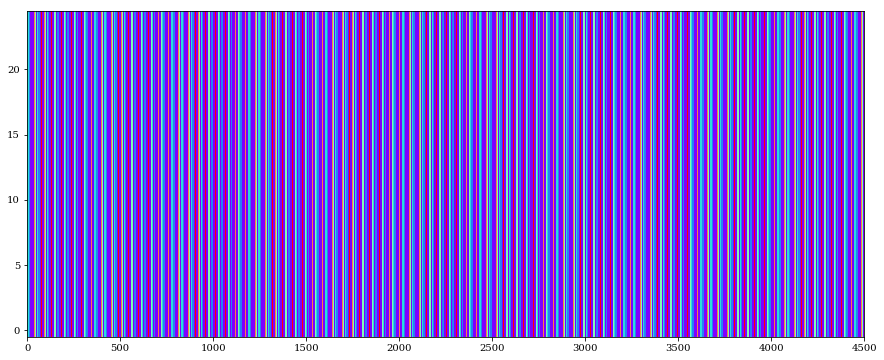

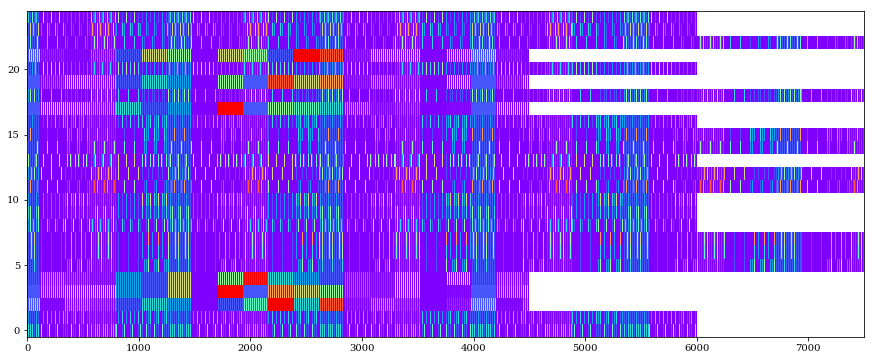

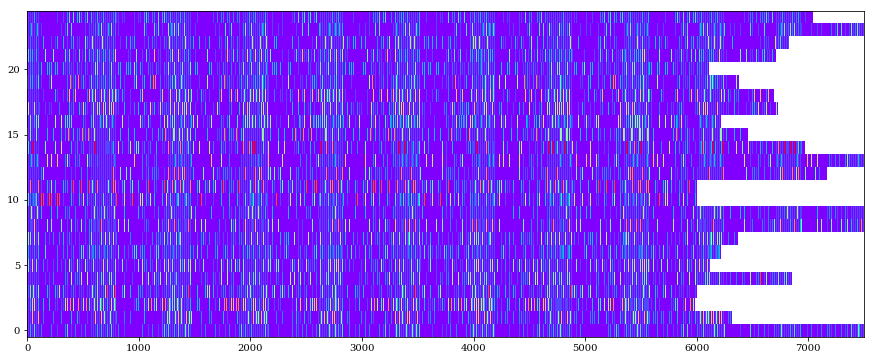

In [6]:
base_dir = '../../../target/thingml-bytes-logs/nodejs/'

if debug:
    base_positions = np.array(loadAllPositions(base_dir+'base/nodejs', N, pad=True))
    static_positions = np.array(loadAllPositions(base_dir+'static/nodejs', N, pad=True))
    runtime_positions = np.array(loadAllPositions(base_dir+'dynamic/nodejs', N, pad=True))

    plt.figure(1, figsize=(15,6))
    plt.imshow(base_positions, interpolation='nearest', origin='lower', aspect='auto', cmap=colormap)
    plt.savefig('picture_raw_positions_base.png', dpi=300)
    plt.show()
    plt.figure(2, figsize=(15,6))
    plt.imshow(static_positions, interpolation='nearest', origin='lower', aspect='auto', cmap=colormap)
    plt.savefig('picture_raw_positions_static.png', dpi=300)
    plt.show()
    plt.figure(3, figsize=(15,6))
    plt.imshow(runtime_positions, interpolation='nearest', origin='lower', aspect='auto', cmap=colormap)
    plt.savefig('picture_raw_positions_runtime.png', dpi=300)
    plt.show()

In [7]:
def split_train_test(data, train_ratio = 0.67):
    train_test = np.empty([len(data),2], dtype=object)
    for i in range(0,len(data)):
        train_size = int(len(data[i]) * train_ratio)
        test_size = len(data[i]) - train_size
        train, test = data[i][0:train_size], data[i][train_size:len(data[i])]
        train_test[i][0] = train 
        train_test[i][1] = test
    return train_test

#Scale data to fit into y=[0,1]
#train = MinMaxScaler().fit_transform(train.reshape(-1, 1))
#test = MinMaxScaler().fit_transform(test.reshape(-1, 1))

base_positions = np.array(loadAllPositions(base_dir+'base/nodejs', N))
static_positions = np.array(loadAllPositions(base_dir+'static/nodejs', N))
runtime_positions = np.array(loadAllPositions(base_dir+'dynamic/nodejs', N))

base = split_train_test(base_positions)
static = split_train_test(static_positions)
runtime = split_train_test(runtime_positions)

base_train = np.array(base[:, 0])
base_test = np.array(base[:, 1])
static_train = np.array(static[:, 0])
static_test = np.array(static[:, 1])
runtime_train = np.array(runtime[:, 0])
runtime_test = np.array(runtime[:, 1])

In [8]:
number_of_interactions = 3
size_of_window = number_of_interactions * size_of_interaction * size_of_msg

"""
See https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg   

In [9]:
def reshape(train, test):
    train_X = np.array(train.iloc[:,0:-1])
    train_Y = np.array(train.iloc[:,-1])
    test_X = np.array(test.iloc[:,0:-1])
    test_Y = np.array(test.iloc[:,-1])

    train_Y = np.reshape(train_Y, (train_Y.shape[0],1))
    test_Y = np.reshape(test_Y, (test_Y.shape[0],1))

    #FIXME: make a function
    n = train_X.shape[0]
    L = 3
    X_train_seq = []
    Y_train_seq = []
    for k in range(n - L + 1):
        X_train_seq.append(train_X[k : k + L])
        Y_train_seq.append(train_Y[k : k + L])
    train_X = np.array(X_train_seq)
    train_Y = np.array(Y_train_seq)

    #FIXME: make a function
    n = test_X.shape[0]
    L = 3
    X_test_seq = []
    Y_test_seq = []
    for k in range(n - L + 1):
        X_test_seq.append(test_X[k : k + L])
        Y_test_seq.append(test_Y[k : k + L])
    test_X = np.array(X_test_seq)
    test_Y = np.array(Y_test_seq)
    
    return train_X, train_Y, test_X, test_Y

def keras_model(x, y):    
    model = keras.Sequential()
    model.add(keras.layers.Dense(x, input_shape=(y, x)))
    if cuda:
        model.add(keras.layers.Bidirectional(keras.layers.CuDNNLSTM(x, return_sequences=True)))
    else:
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(x, return_sequences=True), input_shape=(y, x)))
    model.add(keras.layers.Dense(x))
    model.add(keras.layers.Dense(1))
    model.compile(loss="mse", optimizer="adam")
#     model.summary()
    return model

def train_and_save(model, train_X, train_Y, test_X, test_Y, mode, xp, save=False):
    earlystop_loss = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0025, patience=8, verbose=1)
    earlystop_val_loss = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0025, patience=8, verbose=1)
    callbacks_list = [earlystop_loss, earlystop_val_loss]
    
    model.fit(train_X, train_Y, batch_size=12, epochs=100, validation_split=0.1, verbose=1, callbacks=callbacks_list)

    if save:
        keras.models.save_model(model, base_dir + mode + str(xp) + '.h5', overwrite=True, include_optimizer=True)
#     if debug:
#         result = model.evaluate(test_X, test_Y)
#         print(result)
    return model

In [10]:
def predict(model, test_X, test_Y):

    predictions = model.predict(test_X)
    predictions = np.round(predictions)

    error = np.abs(test_Y.flatten() - predictions.flatten())
    condition = np.equal(error, 0)
    matches = np.extract(condition, error)

    RMSD = round(math.sqrt(np.sum(error**2)/len(error)),2)
    error_ratio = 100-round((len(matches)/len(error)*100),2)

    return error_ratio, RMSD

In [11]:
def xp(train_set, test_set, mode):
    print('xp ', mode)
    for i in range(0, N):
        print('    #', str(i))
        train = series_to_supervised(list(train_set[i]), size_of_window, 1)
        test = series_to_supervised(list(test_set[i]), size_of_window, 1) 
        train_X, train_Y, test_X, test_Y = reshape(train, test)
        model = keras_model(train_X.shape[2], train_X.shape[1])
        train_start = datetime.datetime.now()
        model = train_and_save(model, train_X, train_Y, test_X, test_Y, mode, i, save=True)
        train_stop = predict_start = datetime.datetime.now()
        match_ratio, RMSD = predict(model, test_X, test_Y)
        predict_stop = datetime.datetime.now()
        train_duration = train_stop - train_start
        predict_duration = predict_stop - predict_start
        print('RMSD = ', RMSD)
        print(match_ratio, '% error')
        print('training duration = ', train_duration)
        print('prediction duration = ', predict_duration)
        yield match_ratio, RMSD, train_duration, predict_duration

In [12]:
base_xp = xp(base_train, base_test, 'base')
base_results = list(base_xp)

static_xp = xp(static_train, static_test, 'static')
static_results = list(static_xp)

runtime_xp = xp(runtime_train, runtime_test, 'runtime')
runtime_results = list(runtime_xp)

xp  base
    # 0
Train on 2663 samples, validate on 296 samples
Epoch 1/100
2663/2663 [==============================] - 7s 3ms/step - loss: 0.1480 - val_loss: 0.0012
Epoch 2/100
2663/2663 [==============================] - 2s 663us/step - loss: 3.0337e-04 - val_loss: 1.8497e-05
Epoch 3/100
2663/2663 [==============================] - 2s 741us/step - loss: 5.1306e-06 - val_loss: 2.1967e-07
Epoch 4/100
2663/2663 [==============================] - 2s 734us/step - loss: 5.7031e-08 - val_loss: 2.6765e-09
Epoch 5/100
2663/2663 [==============================] - 2s 694us/step - loss: 4.7659e-09 - val_loss: 6.1681e-09
Epoch 6/100
2663/2663 [==============================] - 2s 661us/step - loss: 2.4981e-08 - val_loss: 2.0602e-08
Epoch 7/100
2663/2663 [==============================] - 2s 666us/step - loss: 1.7227e-07 - val_loss: 1.3981e-06
Epoch 8/100
2663/2663 [==============================] - 2s 659us/step - loss: 2.6244e-04 - val_loss: 2.4358e-04
Epoch 9/100
2663/2663 [===================

RMSD =  0.0
0.0 % error
training duration =  0:00:19.558373
prediction duration =  0:00:00.497164
    # 7
Train on 2663 samples, validate on 296 samples
Epoch 1/100
2663/2663 [==============================] - 4s 1ms/step - loss: 0.1082 - val_loss: 8.0245e-04
Epoch 2/100
2663/2663 [==============================] - 2s 680us/step - loss: 1.4345e-04 - val_loss: 2.1744e-06
Epoch 3/100
2663/2663 [==============================] - 2s 658us/step - loss: 2.2510e-07 - val_loss: 3.0791e-09
Epoch 4/100
2663/2663 [==============================] - 2s 659us/step - loss: 4.2128e-10 - val_loss: 2.2059e-11
Epoch 5/100
2663/2663 [==============================] - 2s 689us/step - loss: 2.5993e-10 - val_loss: 2.2371e-09
Epoch 6/100
2663/2663 [==============================] - 2s 675us/step - loss: 3.9736e-07 - val_loss: 1.5943e-06
Epoch 7/100
2663/2663 [==============================] - 2s 672us/step - loss: 0.0056 - val_loss: 3.0298e-04
Epoch 8/100
2663/2663 [==============================] - 2s 678us/

2663/2663 [==============================] - 2s 685us/step - loss: 1.8336e-04 - val_loss: 2.1966e-06
Epoch 00009: early stopping
RMSD =  0.0
0.0 % error
training duration =  0:00:21.677670
prediction duration =  0:00:00.809505
    # 14
Train on 2663 samples, validate on 296 samples
Epoch 1/100
2663/2663 [==============================] - 5s 2ms/step - loss: 0.1423 - val_loss: 0.0014
Epoch 2/100
2663/2663 [==============================] - 2s 696us/step - loss: 3.3253e-04 - val_loss: 1.2951e-05
Epoch 3/100
2663/2663 [==============================] - 2s 689us/step - loss: 2.5555e-06 - val_loss: 9.0704e-08
Epoch 4/100
2663/2663 [==============================] - 2s 697us/step - loss: 2.1835e-08 - val_loss: 6.0797e-10
Epoch 5/100
2663/2663 [==============================] - 2s 691us/step - loss: 1.4902e-10 - val_loss: 1.4790e-12
Epoch 6/100
2663/2663 [==============================] - 2s 695us/step - loss: 3.8662e-13 - val_loss: 5.5699e-14
Epoch 7/100
2663/2663 [==========================

2663/2663 [==============================] - 2s 718us/step - loss: 5.2825e-14 - val_loss: 2.3924e-14
Epoch 9/100
2663/2663 [==============================] - 2s 712us/step - loss: 3.2572e-14 - val_loss: 3.8308e-14
Epoch 10/100
2663/2663 [==============================] - 2s 712us/step - loss: 2.8549e-14 - val_loss: 4.8251e-14
Epoch 00010: early stopping
RMSD =  0.0
0.0 % error
training duration =  0:00:26.007396
prediction duration =  0:00:01.152480
    # 21
Train on 2663 samples, validate on 296 samples
Epoch 1/100
2663/2663 [==============================] - 6s 2ms/step - loss: 0.1703 - val_loss: 0.0012
Epoch 2/100
2663/2663 [==============================] - 2s 716us/step - loss: 2.5255e-04 - val_loss: 9.6709e-06
Epoch 3/100
2663/2663 [==============================] - 2s 709us/step - loss: 2.7382e-06 - val_loss: 3.2078e-07
Epoch 4/100
2663/2663 [==============================] - 2s 719us/step - loss: 9.0043e-08 - val_loss: 1.1588e-08
Epoch 5/100
2663/2663 [=========================

Epoch 6/100
2663/2663 [==============================] - 2s 724us/step - loss: 2.4460e-14 - val_loss: 1.6418e-14
Epoch 7/100
2663/2663 [==============================] - 2s 727us/step - loss: 2.3790e-14 - val_loss: 1.3908e-14
Epoch 8/100
2663/2663 [==============================] - 2s 728us/step - loss: 1.7567e-14 - val_loss: 4.1507e-14
Epoch 9/100
2663/2663 [==============================] - 2s 725us/step - loss: 2.5500e-14 - val_loss: 4.1088e-14
Epoch 00009: early stopping
RMSD =  0.0
0.0 % error
training duration =  0:00:26.153732
prediction duration =  0:00:01.483324
    # 3
Train on 2663 samples, validate on 296 samples
Epoch 1/100
2663/2663 [==============================] - 7s 3ms/step - loss: 0.4324 - val_loss: 1.8104e-04
Epoch 2/100
2663/2663 [==============================] - 2s 728us/step - loss: 1.8337e-05 - val_loss: 1.3047e-07
Epoch 3/100
2663/2663 [==============================] - 2s 733us/step - loss: 1.6507e-08 - val_loss: 4.0221e-11
Epoch 4/100
2663/2663 [===========

3567/3567 [==============================] - 3s 747us/step - loss: 2.5914e-08 - val_loss: 3.0924e-07
Epoch 6/100
3567/3567 [==============================] - 3s 745us/step - loss: 0.0011 - val_loss: 0.0022
Epoch 7/100
3567/3567 [==============================] - 3s 748us/step - loss: 4.8150e-04 - val_loss: 6.1203e-05
Epoch 8/100
3567/3567 [==============================] - 3s 752us/step - loss: 4.2577e-05 - val_loss: 7.5244e-06
Epoch 9/100
3567/3567 [==============================] - 3s 754us/step - loss: 0.0011 - val_loss: 9.7649e-04
Epoch 00009: early stopping
RMSD =  0.0
0.0 % error
training duration =  0:00:34.665165
prediction duration =  0:00:01.878620
    # 10
Train on 3567 samples, validate on 397 samples
Epoch 1/100
3567/3567 [==============================] - 9s 2ms/step - loss: 0.0724 - val_loss: 1.5574e-04
Epoch 2/100
3567/3567 [==============================] - 3s 751us/step - loss: 2.4567e-05 - val_loss: 9.3672e-07
Epoch 3/100
3567/3567 [==============================] - 

3567/3567 [==============================] - 3s 763us/step - loss: 6.9792e-06 - val_loss: 6.3508e-06
Epoch 5/100
3567/3567 [==============================] - 3s 774us/step - loss: 7.3561e-04 - val_loss: 9.4827e-04
Epoch 6/100
3567/3567 [==============================] - 3s 763us/step - loss: 1.2131e-04 - val_loss: 1.1927e-05
Epoch 7/100
3567/3567 [==============================] - 3s 768us/step - loss: 1.3598e-04 - val_loss: 1.2027e-04
Epoch 8/100
3567/3567 [==============================] - 3s 771us/step - loss: 2.7336e-04 - val_loss: 1.0181e-04
Epoch 9/100
3567/3567 [==============================] - 3s 768us/step - loss: 0.0013 - val_loss: 7.3017e-05
Epoch 00009: early stopping
RMSD =  0.0
0.0 % error
training duration =  0:00:37.253764
prediction duration =  0:00:02.287935
    # 17
Train on 2663 samples, validate on 296 samples
Epoch 1/100
2663/2663 [==============================] - 9s 4ms/step - loss: 0.3512 - val_loss: 5.7259e-05
Epoch 2/100
2663/2663 [==========================

3567/3567 [==============================] - 3s 786us/step - loss: 4.2141e-11 - val_loss: 9.9528e-14
Epoch 4/100
3567/3567 [==============================] - 3s 790us/step - loss: 3.6335e-14 - val_loss: 4.1748e-14
Epoch 5/100
3567/3567 [==============================] - 3s 789us/step - loss: 2.4620e-14 - val_loss: 1.9304e-14
Epoch 6/100
3567/3567 [==============================] - 3s 789us/step - loss: 2.0286e-14 - val_loss: 4.1117e-14
Epoch 7/100
3567/3567 [==============================] - 3s 791us/step - loss: 2.3495e-14 - val_loss: 1.3218e-13
Epoch 8/100
3567/3567 [==============================] - 3s 785us/step - loss: 3.4024e-04 - val_loss: 0.0203
Epoch 9/100
3567/3567 [==============================] - 3s 788us/step - loss: 0.0058 - val_loss: 3.2638e-07
Epoch 00009: early stopping
RMSD =  0.0
0.0 % error
training duration =  0:00:39.894490
prediction duration =  0:00:02.687559
    # 24
Train on 3567 samples, validate on 397 samples
Epoch 1/100
3567/3567 [========================

3559/3559 [==============================] - 3s 790us/step - loss: 0.1664 - val_loss: 0.2284
Epoch 7/100
3559/3559 [==============================] - 3s 796us/step - loss: 0.1567 - val_loss: 0.2310
Epoch 8/100
3559/3559 [==============================] - ETA: 0s - loss: 0.153 - 3s 798us/step - loss: 0.1527 - val_loss: 0.1905
Epoch 9/100
3559/3559 [==============================] - 3s 794us/step - loss: 0.1452 - val_loss: 0.2118
Epoch 10/100
3559/3559 [==============================] - 3s 790us/step - loss: 0.1361 - val_loss: 0.2055
Epoch 11/100
3559/3559 [==============================] - 3s 792us/step - loss: 0.1371 - val_loss: 0.2014
Epoch 12/100
3559/3559 [==============================] - 3s 794us/step - loss: 0.1305 - val_loss: 0.1851
Epoch 13/100
3559/3559 [==============================] - 3s 800us/step - loss: 0.1288 - val_loss: 0.2218
Epoch 14/100
3559/3559 [==============================] - 3s 797us/step - loss: 0.1245 - val_loss: 0.1844
Epoch 15/100
3559/3559 [==============

3639/3639 [==============================] - 3s 795us/step - loss: 0.1555 - val_loss: 0.2081
Epoch 16/100
3639/3639 [==============================] - 3s 800us/step - loss: 0.1587 - val_loss: 0.1829
Epoch 17/100
3639/3639 [==============================] - 3s 801us/step - loss: 0.1529 - val_loss: 0.1849
Epoch 18/100
3639/3639 [==============================] - 3s 805us/step - loss: 0.1534 - val_loss: 0.2234
Epoch 19/100
3639/3639 [==============================] - 3s 802us/step - loss: 0.1519 - val_loss: 0.1860
Epoch 20/100
3639/3639 [==============================] - 3s 798us/step - loss: 0.1502 - val_loss: 0.2030
Epoch 21/100
3639/3639 [==============================] - 3s 800us/step - loss: 0.1472 - val_loss: 0.1586
Epoch 00021: early stopping
RMSD =  0.44
3.3599999999999994 % error
training duration =  0:01:18.241635
prediction duration =  0:00:03.066639
    # 6
Train on 3697 samples, validate on 411 samples
Epoch 1/100
3697/3697 [==============================] - 13s 3ms/step - lo

4472/4472 [==============================] - 4s 810us/step - loss: 0.1623 - val_loss: 0.2069
Epoch 26/100
4472/4472 [==============================] - 4s 810us/step - loss: 0.1655 - val_loss: 0.2120
Epoch 27/100
4472/4472 [==============================] - 4s 810us/step - loss: 0.1598 - val_loss: 0.2124
Epoch 00027: early stopping
RMSD =  0.39
2.5900000000000034 % error
training duration =  0:01:56.382290
prediction duration =  0:00:03.315818
    # 9
Train on 4472 samples, validate on 497 samples
Epoch 1/100
4472/4472 [==============================] - 14s 3ms/step - loss: 0.4034 - val_loss: 0.2058
Epoch 2/100
4472/4472 [==============================] - 4s 817us/step - loss: 0.0940 - val_loss: 0.1138
Epoch 3/100
4472/4472 [==============================] - 4s 818us/step - loss: 0.0604 - val_loss: 0.1157
Epoch 4/100
4472/4472 [==============================] - 4s 818us/step - loss: 0.0505 - val_loss: 0.1009
Epoch 5/100
4472/4472 [==============================] - 4s 818us/step - loss: 

Epoch 00018: early stopping
RMSD =  0.6
4.090000000000003 % error
training duration =  0:01:12.099553
prediction duration =  0:00:03.481410
    # 12
Train on 4272 samples, validate on 475 samples
Epoch 1/100
4272/4272 [==============================] - 15s 3ms/step - loss: 0.8836 - val_loss: 0.4397
Epoch 2/100
4272/4272 [==============================] - 4s 823us/step - loss: 0.3547 - val_loss: 0.3546
Epoch 3/100
4272/4272 [==============================] - 4s 822us/step - loss: 0.3151 - val_loss: 0.3213
Epoch 4/100
4272/4272 [==============================] - 4s 823us/step - loss: 0.2776 - val_loss: 0.3010
Epoch 5/100
4272/4272 [==============================] - 4s 821us/step - loss: 0.2623 - val_loss: 0.2938
Epoch 6/100
4272/4272 [==============================] - 4s 825us/step - loss: 0.2535 - val_loss: 0.2992
Epoch 7/100
4272/4272 [==============================] - 4s 826us/step - loss: 0.2471 - val_loss: 0.2817
Epoch 8/100
4272/4272 [==============================] - 4s 829us/step

4153/4153 [==============================] - 3s 826us/step - loss: 0.1561 - val_loss: 0.3477
Epoch 15/100
4153/4153 [==============================] - 3s 829us/step - loss: 0.1565 - val_loss: 0.3011
Epoch 16/100
4153/4153 [==============================] - 3s 828us/step - loss: 0.1743 - val_loss: 0.3048
Epoch 00016: early stopping
RMSD =  0.44
4.189999999999998 % error
training duration =  0:01:14.849203
prediction duration =  0:00:03.725826
    # 15
Train on 3845 samples, validate on 428 samples
Epoch 1/100
3845/3845 [==============================] - 15s 4ms/step - loss: 0.7945 - val_loss: 0.2713
Epoch 2/100
3845/3845 [==============================] - 3s 834us/step - loss: 0.2858 - val_loss: 0.2057
Epoch 3/100
3845/3845 [==============================] - 3s 832us/step - loss: 0.2334 - val_loss: 0.1873
Epoch 4/100
3845/3845 [==============================] - 3s 828us/step - loss: 0.1976 - val_loss: 0.1447
Epoch 5/100
3845/3845 [==============================] - 3s 832us/step - loss: 

4005/4005 [==============================] - 3s 834us/step - loss: 0.1690 - val_loss: 0.2458
Epoch 25/100
4005/4005 [==============================] - 3s 838us/step - loss: 0.1734 - val_loss: 0.2455
Epoch 26/100
4005/4005 [==============================] - 3s 834us/step - loss: 0.1667 - val_loss: 0.2290
Epoch 27/100
4005/4005 [==============================] - 3s 839us/step - loss: 0.1634 - val_loss: 0.2280
Epoch 28/100
4005/4005 [==============================] - 3s 843us/step - loss: 0.1638 - val_loss: 0.2278
Epoch 29/100
4005/4005 [==============================] - 3s 837us/step - loss: 0.1654 - val_loss: 0.2312
Epoch 00029: early stopping
RMSD =  0.49
4.329999999999998 % error
training duration =  0:01:58.415259
prediction duration =  0:00:03.890374
    # 18
Train on 3983 samples, validate on 443 samples
Epoch 1/100
3983/3983 [==============================] - 16s 4ms/step - loss: 0.7773 - val_loss: 0.1947
Epoch 2/100
3983/3983 [==============================] - 3s 840us/step - los

3636/3636 [==============================] - 3s 853us/step - loss: 0.0418 - val_loss: 0.0775
Epoch 15/100
3636/3636 [==============================] - 3s 852us/step - loss: 0.0421 - val_loss: 0.0798
Epoch 00015: early stopping
RMSD =  0.23
2.7900000000000063 % error
training duration =  0:01:08.145845
prediction duration =  0:00:04.075565
    # 21
Train on 3997 samples, validate on 445 samples
Epoch 1/100
3997/3997 [==============================] - 16s 4ms/step - loss: 0.4578 - val_loss: 0.1969
Epoch 2/100
3997/3997 [==============================] - 3s 864us/step - loss: 0.1688 - val_loss: 0.1724
Epoch 3/100
3997/3997 [==============================] - 3s 854us/step - loss: 0.1351 - val_loss: 0.1477
Epoch 4/100
3997/3997 [==============================] - 3s 854us/step - loss: 0.1187 - val_loss: 0.1281
Epoch 5/100
3997/3997 [==============================] - 3s 862us/step - loss: 0.1061 - val_loss: 0.1153
Epoch 6/100
3997/3997 [==============================] - 3s 859us/step - loss: 

4472/4472 [==============================] - 4s 860us/step - loss: 0.0563 - val_loss: 0.0638
Epoch 17/100
4472/4472 [==============================] - 4s 860us/step - loss: 0.0581 - val_loss: 0.0571
Epoch 18/100
4472/4472 [==============================] - 4s 865us/step - loss: 0.0558 - val_loss: 0.0538
Epoch 19/100
4472/4472 [==============================] - 4s 861us/step - loss: 0.0549 - val_loss: 0.0562
Epoch 20/100
4472/4472 [==============================] - 4s 864us/step - loss: 0.0544 - val_loss: 0.0551
Epoch 21/100
4472/4472 [==============================] - 4s 861us/step - loss: 0.0532 - val_loss: 0.0515
Epoch 22/100
4472/4472 [==============================] - 4s 865us/step - loss: 0.0527 - val_loss: 0.0645
Epoch 23/100
4472/4472 [==============================] - 4s 862us/step - loss: 0.0527 - val_loss: 0.0562
Epoch 24/100
4472/4472 [==============================] - 4s 863us/step - loss: 0.0544 - val_loss: 0.0567
Epoch 25/100
4472/4472 [==============================] - 4

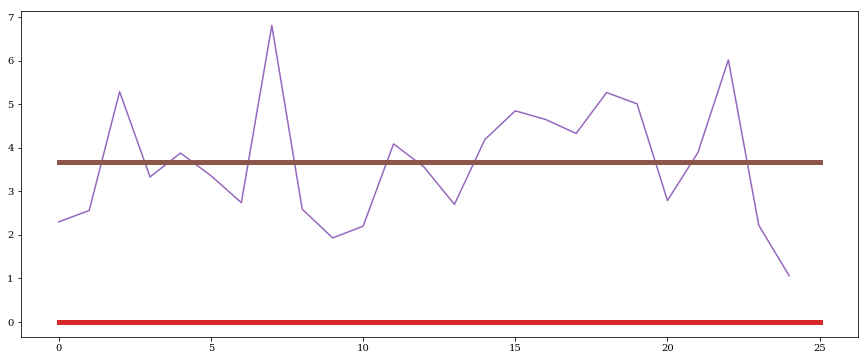

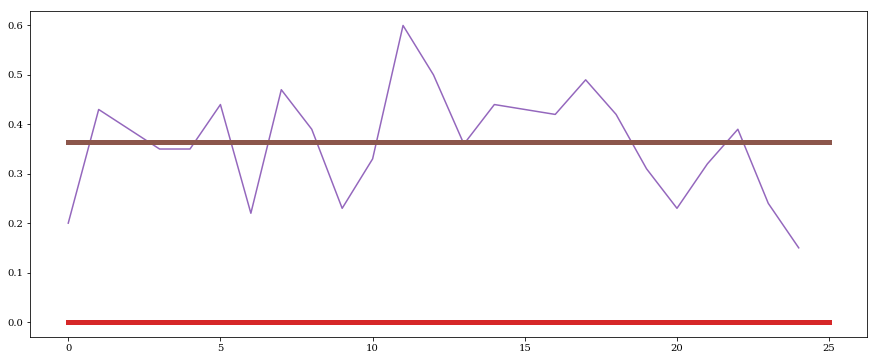

In [13]:
def get_errors_and_rmsd(results, errors, rmsd):
    for e,rms,_,_ in results:
        errors.append(e)
        rmsd.append(rms)

        
base_errors = []
base_rmsd = []
get_errors_and_rmsd(base_results, base_errors, base_rmsd)

static_errors = []
static_rmsd = []
get_errors_and_rmsd(static_results, static_errors, static_rmsd)

runtime_errors = []
runtime_rmsd = []
get_errors_and_rmsd(runtime_results, runtime_errors, runtime_rmsd)


plt.figure(4, figsize=(15,6))
plt.plot(base_errors)
mean = np.mean(base_errors)
plt.plot([0, len(base_errors)], [mean, mean], linewidth=5)
plt.plot(static_errors)
mean = np.mean(static_errors)
plt.plot([0, len(static_errors)], [mean, mean], linewidth=5)
plt.plot(runtime_errors)
mean = np.mean(runtime_errors)
plt.plot([0, len(runtime_errors)], [mean, mean], linewidth=5)
plt.show()

plt.figure(5, figsize=(15,6))
plt.plot(base_rmsd)
mean = np.mean(base_rmsd)
plt.plot([0, len(base_rmsd)], [mean, mean], linewidth=5)
plt.plot(static_rmsd)
mean = np.mean(static_rmsd)
plt.plot([0, len(static_rmsd)], [mean, mean], linewidth=5)
plt.plot(runtime_rmsd)
mean = np.mean(runtime_rmsd)
plt.plot([0, len(runtime_rmsd)], [mean, mean], linewidth=5)
plt.show()

In [14]:
def xp2(train_set, test_set, mode):
    for i in range(0,N):
        model = keras.models.load_model(base_dir + mode + str(i) + '.h5')
        for j in range(0,N):
            print('    using model ', str(i), ' on data coming from ', str(j))
            train = series_to_supervised(list(train_set[j]), size_of_window, 1)
            test = series_to_supervised(list(test_set[j]), size_of_window, 1) 
            train_X, train_Y, test_X, test_Y = reshape(train, test)
            predict_start = datetime.datetime.now()
            match_ratio, RMSD = predict(model, test_X, test_Y)
            predict_stop = datetime.datetime.now()
            predict_duration = predict_stop - predict_start
            print('RMSD = ', RMSD)
            print(match_ratio, '% error')
            print('prediction duration = ', predict_duration)
            yield match_ratio, RMSD, -1, predict_duration #-1 for no training

base_results = xp2(base_train, base_test, 'base')
base_results = list(base_results)

static_results = xp2(static_train, static_test, 'static')
static_results = list(static_results)

runtime_results = xp2(runtime_train, runtime_test, 'runtime')
runtime_results = list(runtime_results)

    using model  0  on data coming from  0
RMSD =  0.0
0.0 % error
prediction duration =  0:00:04.427926
    using model  0  on data coming from  1
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.190508
    using model  0  on data coming from  2
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.194517
    using model  0  on data coming from  3
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.190509
    using model  0  on data coming from  4
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.191510
    using model  0  on data coming from  5
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.190505
    using model  0  on data coming from  6
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.191477
    using model  0  on data coming from  7
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.191538
    using model  0  on data coming from  8
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.194492
    using model  0  on data coming from  9
RMSD =  0.0


RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.189478
    using model  3  on data coming from  4
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.187499
    using model  3  on data coming from  5
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.186497
    using model  3  on data coming from  6
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.183488
    using model  3  on data coming from  7
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.190508
    using model  3  on data coming from  8
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.185493
    using model  3  on data coming from  9
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.191540
    using model  3  on data coming from  10
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.191480
    using model  3  on data coming from  11
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.189538
    using model  3  on data coming from  12
RMSD =  0.0
0.0 % error
prediction duration =  0:00:

RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.195519
    using model  6  on data coming from  7
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.196491
    using model  6  on data coming from  8
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.199564
    using model  6  on data coming from  9
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.197552
    using model  6  on data coming from  10
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.196525
    using model  6  on data coming from  11
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.195548
    using model  6  on data coming from  12
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.196490
    using model  6  on data coming from  13
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.197525
    using model  6  on data coming from  14
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.198523
    using model  6  on data coming from  15
RMSD =  0.0
0.0 % error
prediction duration =  0:

RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.201509
    using model  9  on data coming from  10
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.201537
    using model  9  on data coming from  11
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.202505
    using model  9  on data coming from  12
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.202510
    using model  9  on data coming from  13
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.202538
    using model  9  on data coming from  14
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.202511
    using model  9  on data coming from  15
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.194492
    using model  9  on data coming from  16
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.201505
    using model  9  on data coming from  17
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.202535
    using model  9  on data coming from  18
RMSD =  0.0
0.0 % error
prediction duration = 

RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.204512
    using model  12  on data coming from  12
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.202539
    using model  12  on data coming from  13
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.201536
    using model  12  on data coming from  14
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.203508
    using model  12  on data coming from  15
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.203542
    using model  12  on data coming from  16
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.202539
    using model  12  on data coming from  17
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.204547
    using model  12  on data coming from  18
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.201535
    using model  12  on data coming from  19
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.203541
    using model  12  on data coming from  20
RMSD =  0.0
0.0 % error
prediction du

RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.209558
    using model  15  on data coming from  14
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.208555
    using model  15  on data coming from  15
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.209559
    using model  15  on data coming from  16
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.208555
    using model  15  on data coming from  17
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.206550
    using model  15  on data coming from  18
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.206550
    using model  15  on data coming from  19
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.208582
    using model  15  on data coming from  20
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.211577
    using model  15  on data coming from  21
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.208555
    using model  15  on data coming from  22
RMSD =  0.0
0.0 % error
prediction du

RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.211565
    using model  18  on data coming from  16
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.210529
    using model  18  on data coming from  17
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.207516
    using model  18  on data coming from  18
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.211562
    using model  18  on data coming from  19
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.211561
    using model  18  on data coming from  20
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.210535
    using model  18  on data coming from  21
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.209582
    using model  18  on data coming from  22
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.211562
    using model  18  on data coming from  23
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.211535
    using model  18  on data coming from  24
RMSD =  0.0
0.0 % error
prediction du

RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.209525
    using model  21  on data coming from  18
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.212533
    using model  21  on data coming from  19
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.215543
    using model  21  on data coming from  20
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.226632
    using model  21  on data coming from  21
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.217545
    using model  21  on data coming from  22
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.218550
    using model  21  on data coming from  23
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.216574
    using model  21  on data coming from  24
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.214540
    using model  22  on data coming from  0
RMSD =  0.0
0.0 % error
prediction duration =  0:00:06.258323
    using model  22  on data coming from  1
RMSD =  0.0
0.0 % error
prediction dura

RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.216548
    using model  24  on data coming from  20
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.217547
    using model  24  on data coming from  21
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.217552
    using model  24  on data coming from  22
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.222565
    using model  24  on data coming from  23
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.220613
    using model  24  on data coming from  24
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.220614
    using model  0  on data coming from  0
RMSD =  0.0
0.0 % error
prediction duration =  0:00:06.760272
    using model  0  on data coming from  1
RMSD =  0.5
25.03 % error
prediction duration =  0:00:00.301777
    using model  0  on data coming from  2
RMSD =  3.03
62.96 % error
prediction duration =  0:00:00.218551
    using model  0  on data coming from  3
RMSD =  3.08
81.53 % error
prediction du

RMSD =  1.1
62.86 % error
prediction duration =  0:00:00.224597
    using model  2  on data coming from  20
RMSD =  1.68
84.74 % error
prediction duration =  0:00:00.305841
    using model  2  on data coming from  21
RMSD =  1.77
70.19 % error
prediction duration =  0:00:00.224570
    using model  2  on data coming from  22
RMSD =  1.76
89.97 % error
prediction duration =  0:00:00.379035
    using model  2  on data coming from  23
RMSD =  2.23
88.91 % error
prediction duration =  0:00:00.301777
    using model  2  on data coming from  24
RMSD =  1.71
91.67 % error
prediction duration =  0:00:00.306788
    using model  3  on data coming from  0
RMSD =  1.47
77.81 % error
prediction duration =  0:00:07.095418
    using model  3  on data coming from  1
RMSD =  1.07
80.58 % error
prediction duration =  0:00:00.307846
    using model  3  on data coming from  2
RMSD =  1.32
53.58 % error
prediction duration =  0:00:00.228607
    using model  3  on data coming from  3
RMSD =  0.0
0.0 % error


RMSD =  2.93
55.45 % error
prediction duration =  0:00:00.230642
    using model  5  on data coming from  20
RMSD =  1.41
48.63 % error
prediction duration =  0:00:00.308823
    using model  5  on data coming from  21
RMSD =  3.33
51.71 % error
prediction duration =  0:00:00.233621
    using model  5  on data coming from  22
RMSD =  0.68
26.569999999999993 % error
prediction duration =  0:00:00.383050
    using model  5  on data coming from  23
RMSD =  1.85
31.950000000000003 % error
prediction duration =  0:00:00.316870
    using model  5  on data coming from  24
RMSD =  1.4
37.47 % error
prediction duration =  0:00:00.310827
    using model  6  on data coming from  0
RMSD =  1.33
31.930000000000007 % error
prediction duration =  0:00:07.387423
    using model  6  on data coming from  1
RMSD =  1.05
38.91 % error
prediction duration =  0:00:00.331881
    using model  6  on data coming from  2
RMSD =  3.03
55.45 % error
prediction duration =  0:00:00.241642
    using model  6  on data 

RMSD =  3.03
62.96 % error
prediction duration =  0:00:00.235628
    using model  8  on data coming from  20
RMSD =  0.91
57.0 % error
prediction duration =  0:00:00.312833
    using model  8  on data coming from  21
RMSD =  3.53
75.9 % error
prediction duration =  0:00:00.235653
    using model  8  on data coming from  22
RMSD =  1.43
49.99 % error
prediction duration =  0:00:00.390050
    using model  8  on data coming from  23
RMSD =  1.03
40.19 % error
prediction duration =  0:00:00.319850
    using model  8  on data coming from  24
RMSD =  0.83
49.97 % error
prediction duration =  0:00:00.316869
    using model  9  on data coming from  0
RMSD =  0.6
23.61 % error
prediction duration =  0:00:07.712582
    using model  9  on data coming from  1
RMSD =  0.46
20.840000000000003 % error
prediction duration =  0:00:00.323891
    using model  9  on data coming from  2
RMSD =  2.96
64.75 % error
prediction duration =  0:00:00.238632
    using model  9  on data coming from  3
RMSD =  3.52


RMSD =  1.25
60.0 % error
prediction duration =  0:00:00.405104
    using model  11  on data coming from  19
RMSD =  3.38
88.9 % error
prediction duration =  0:00:00.241668
    using model  11  on data coming from  20
RMSD =  1.58
66.63 % error
prediction duration =  0:00:00.323860
    using model  11  on data coming from  21
RMSD =  3.82
83.34 % error
prediction duration =  0:00:00.237600
    using model  11  on data coming from  22
RMSD =  0.57
22.17 % error
prediction duration =  0:00:00.402069
    using model  11  on data coming from  23
RMSD =  2.03
47.14 % error
prediction duration =  0:00:00.322885
    using model  11  on data coming from  24
RMSD =  1.64
63.89 % error
prediction duration =  0:00:00.322885
    using model  12  on data coming from  0
RMSD =  1.37
48.61 % error
prediction duration =  0:00:08.057783
    using model  12  on data coming from  1
RMSD =  0.99
38.86 % error
prediction duration =  0:00:00.328868
    using model  12  on data coming from  2
RMSD =  2.84
53

RMSD =  1.17
36.57 % error
prediction duration =  0:00:00.404101
    using model  14  on data coming from  19
RMSD =  3.31
72.15 % error
prediction duration =  0:00:00.239639
    using model  14  on data coming from  20
RMSD =  1.57
62.53 % error
prediction duration =  0:00:00.321856
    using model  14  on data coming from  21
RMSD =  3.74
66.57 % error
prediction duration =  0:00:00.242644
    using model  14  on data coming from  22
RMSD =  0.66
23.25 % error
prediction duration =  0:00:00.404070
    using model  14  on data coming from  23
RMSD =  1.98
48.6 % error
prediction duration =  0:00:00.323862
    using model  14  on data coming from  24
RMSD =  1.58
52.77 % error
prediction duration =  0:00:00.320880
    using model  15  on data coming from  0
RMSD =  1.33
30.540000000000006 % error
prediction duration =  0:00:08.447049
    using model  15  on data coming from  1
RMSD =  1.18
40.3 % error
prediction duration =  0:00:00.330880
    using model  15  on data coming from  2
RM

RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.245653
    using model  17  on data coming from  18
RMSD =  1.47
81.12 % error
prediction duration =  0:00:00.409114
    using model  17  on data coming from  19
RMSD =  1.17
57.27 % error
prediction duration =  0:00:00.244625
    using model  17  on data coming from  20
RMSD =  1.33
59.77 % error
prediction duration =  0:00:00.330906
    using model  17  on data coming from  21
RMSD =  1.78
61.11 % error
prediction duration =  0:00:00.242673
    using model  17  on data coming from  22
RMSD =  1.42
64.41 % error
prediction duration =  0:00:00.410092
    using model  17  on data coming from  23
RMSD =  1.9
69.4 % error
prediction duration =  0:00:00.327870
    using model  17  on data coming from  24
RMSD =  1.31
72.26 % error
prediction duration =  0:00:00.330852
    using model  18  on data coming from  0
RMSD =  1.28
34.81 % error
prediction duration =  0:00:09.646809
    using model  18  on data coming from  1
RMSD =  1.01
36.1

RMSD =  2.9
70.31 % error
prediction duration =  0:00:00.255681
    using model  20  on data coming from  18
RMSD =  1.27
43.34 % error
prediction duration =  0:00:00.418102
    using model  20  on data coming from  19
RMSD =  3.31
64.72999999999999 % error
prediction duration =  0:00:00.249664
    using model  20  on data coming from  20
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.337899
    using model  20  on data coming from  21
RMSD =  3.58
57.27 % error
prediction duration =  0:00:00.248664
    using model  20  on data coming from  22
RMSD =  1.32
31.069999999999993 % error
prediction duration =  0:00:00.417137
    using model  20  on data coming from  23
RMSD =  1.54
41.72 % error
prediction duration =  0:00:00.336895
    using model  20  on data coming from  24
RMSD =  0.53
27.72 % error
prediction duration =  0:00:00.334920
    using model  21  on data coming from  0
RMSD =  1.85
81.96000000000001 % error
prediction duration =  0:00:09.067366
    using model  21  on

RMSD =  0.88
52.75 % error
prediction duration =  0:00:00.345920
    using model  23  on data coming from  17
RMSD =  2.78
66.67 % error
prediction duration =  0:00:00.257684
    using model  23  on data coming from  18
RMSD =  1.35
63.29 % error
prediction duration =  0:00:00.428139
    using model  23  on data coming from  19
RMSD =  3.05
61.07 % error
prediction duration =  0:00:00.256682
    using model  23  on data coming from  20
RMSD =  0.93
52.75 % error
prediction duration =  0:00:00.343943
    using model  23  on data coming from  21
RMSD =  3.47
75.9 % error
prediction duration =  0:00:00.256709
    using model  23  on data coming from  22
RMSD =  1.55
58.87 % error
prediction duration =  0:00:00.429168
    using model  23  on data coming from  23
RMSD =  0.0
0.0 % error
prediction duration =  0:00:00.344917
    using model  23  on data coming from  24
RMSD =  1.02
37.47 % error
prediction duration =  0:00:00.342911
    using model  24  on data coming from  0
RMSD =  0.92
34

RMSD =  1.63
43.79 % error
prediction duration =  0:00:00.413046
    using model  1  on data coming from  15
RMSD =  1.78
61.1 % error
prediction duration =  0:00:00.381041
    using model  1  on data coming from  16
RMSD =  1.27
37.97 % error
prediction duration =  0:00:00.363968
    using model  1  on data coming from  17
RMSD =  1.4
40.82 % error
prediction duration =  0:00:00.397083
    using model  1  on data coming from  18
RMSD =  1.48
44.72 % error
prediction duration =  0:00:00.396080
    using model  1  on data coming from  19
RMSD =  1.59
54.15 % error
prediction duration =  0:00:00.380008
    using model  1  on data coming from  20
RMSD =  0.94
43.49 % error
prediction duration =  0:00:00.364997
    using model  1  on data coming from  21
RMSD =  1.36
40.32 % error
prediction duration =  0:00:00.397083
    using model  1  on data coming from  22
RMSD =  1.27
47.88 % error
prediction duration =  0:00:00.400065
    using model  1  on data coming from  23
RMSD =  0.98
31.59999

RMSD =  1.17
35.17 % error
prediction duration =  0:00:00.451227
    using model  4  on data coming from  14
RMSD =  1.96
39.03 % error
prediction duration =  0:00:00.419115
    using model  4  on data coming from  15
RMSD =  1.65
47.47 % error
prediction duration =  0:00:00.387055
    using model  4  on data coming from  16
RMSD =  1.59
37.9 % error
prediction duration =  0:00:00.371990
    using model  4  on data coming from  17
RMSD =  1.15
24.86 % error
prediction duration =  0:00:00.404076
    using model  4  on data coming from  18
RMSD =  1.48
30.11 % error
prediction duration =  0:00:00.402070
    using model  4  on data coming from  19
RMSD =  1.68
43.34 % error
prediction duration =  0:00:00.388058
    using model  4  on data coming from  20
RMSD =  1.14
36.9 % error
prediction duration =  0:00:00.368004
    using model  4  on data coming from  21
RMSD =  0.9
26.269999999999996 % error
prediction duration =  0:00:00.400065
    using model  4  on data coming from  22
RMSD =  1

RMSD =  1.93
32.209999999999994 % error
prediction duration =  0:00:00.374993
    using model  7  on data coming from  12
RMSD =  1.21
22.569999999999993 % error
prediction duration =  0:00:00.446187
    using model  7  on data coming from  13
RMSD =  1.29
43.81 % error
prediction duration =  0:00:00.461254
    using model  7  on data coming from  14
RMSD =  1.6
29.58 % error
prediction duration =  0:00:00.447215
    using model  7  on data coming from  15
RMSD =  1.87
50.54 % error
prediction duration =  0:00:00.399088
    using model  7  on data coming from  16
RMSD =  1.32
36.45 % error
prediction duration =  0:00:00.386054
    using model  7  on data coming from  17
RMSD =  1.0
25.989999999999995 % error
prediction duration =  0:00:00.411108
    using model  7  on data coming from  18
RMSD =  1.64
32.980000000000004 % error
prediction duration =  0:00:00.417137
    using model  7  on data coming from  19
RMSD =  1.69
45.69 % error
prediction duration =  0:00:00.395079
    using mod

RMSD =  1.66
47.57 % error
prediction duration =  0:00:00.471279
    using model  10  on data coming from  9
RMSD =  1.35
49.08 % error
prediction duration =  0:00:00.468271
    using model  10  on data coming from  10
RMSD =  0.33
2.200000000000003 % error
prediction duration =  0:00:00.378031
    using model  10  on data coming from  11
RMSD =  1.89
43.85 % error
prediction duration =  0:00:00.379006
    using model  10  on data coming from  12
RMSD =  1.99
54.06 % error
prediction duration =  0:00:00.447188
    using model  10  on data coming from  13
RMSD =  1.12
32.31 % error
prediction duration =  0:00:00.485292
    using model  10  on data coming from  14
RMSD =  1.96
50.53 % error
prediction duration =  0:00:00.447190
    using model  10  on data coming from  15
RMSD =  1.92
54.0 % error
prediction duration =  0:00:00.403099
    using model  10  on data coming from  16
RMSD =  1.68
39.81 % error
prediction duration =  0:00:00.390063
    using model  10  on data coming from  17


RMSD =  1.44
37.4 % error
prediction duration =  0:00:00.409114
    using model  13  on data coming from  8
RMSD =  1.35
32.31 % error
prediction duration =  0:00:00.483618
    using model  13  on data coming from  9
RMSD =  1.21
41.59 % error
prediction duration =  0:00:00.484314
    using model  13  on data coming from  10
RMSD =  1.5
24.510000000000005 % error
prediction duration =  0:00:00.389061
    using model  13  on data coming from  11
RMSD =  2.12
40.87 % error
prediction duration =  0:00:00.389059
    using model  13  on data coming from  12
RMSD =  1.8
42.97 % error
prediction duration =  0:00:00.462255
    using model  13  on data coming from  13
RMSD =  0.36
2.700000000000003 % error
prediction duration =  0:00:00.484321
    using model  13  on data coming from  14
RMSD =  1.8
35.68000000000001 % error
prediction duration =  0:00:00.454235
    using model  13  on data coming from  15
RMSD =  1.95
47.75 % error
prediction duration =  0:00:00.414128
    using model  13  on 

RMSD =  0.89
30.959999999999994 % error
prediction duration =  0:00:00.404105
    using model  16  on data coming from  7
RMSD =  1.06
31.92 % error
prediction duration =  0:00:00.404103
    using model  16  on data coming from  8
RMSD =  1.15
32.86 % error
prediction duration =  0:00:00.484317
    using model  16  on data coming from  9
RMSD =  1.18
40.22 % error
prediction duration =  0:00:00.479275
    using model  16  on data coming from  10
RMSD =  1.59
35.43000000000001 % error
prediction duration =  0:00:00.390064
    using model  16  on data coming from  11
RMSD =  1.73
33.42 % error
prediction duration =  0:00:00.387057
    using model  16  on data coming from  12
RMSD =  1.29
34.42 % error
prediction duration =  0:00:00.464261
    using model  16  on data coming from  13
RMSD =  1.13
34.22 % error
prediction duration =  0:00:00.486758
    using model  16  on data coming from  14
RMSD =  1.37
36.18 % error
prediction duration =  0:00:00.454208
    using model  16  on data comi

RMSD =  1.23
42.85 % error
prediction duration =  0:00:00.440199
    using model  19  on data coming from  5
RMSD =  1.76
37.54 % error
prediction duration =  0:00:00.401095
    using model  19  on data coming from  6
RMSD =  0.89
31.909999999999997 % error
prediction duration =  0:00:00.404109
    using model  19  on data coming from  7
RMSD =  1.47
39.16 % error
prediction duration =  0:00:00.428139
    using model  19  on data coming from  8
RMSD =  1.51
33.93000000000001 % error
prediction duration =  0:00:00.488325
    using model  19  on data coming from  9
RMSD =  1.01
45.68 % error
prediction duration =  0:00:00.492336
    using model  19  on data coming from  10
RMSD =  1.49
38.57 % error
prediction duration =  0:00:00.393072
    using model  19  on data coming from  11
RMSD =  2.1
44.56 % error
prediction duration =  0:00:00.392070
    using model  19  on data coming from  12
RMSD =  1.74
37.47 % error
prediction duration =  0:00:00.467245
    using model  19  on data coming 

RMSD =  1.24
23.159999999999997 % error
prediction duration =  0:00:00.427165
    using model  22  on data coming from  2
RMSD =  2.13
37.93 % error
prediction duration =  0:00:00.405087
    using model  22  on data coming from  3
RMSD =  1.76
36.71 % error
prediction duration =  0:00:00.403100
    using model  22  on data coming from  4
RMSD =  1.02
26.459999999999994 % error
prediction duration =  0:00:00.451232
    using model  22  on data coming from  5
RMSD =  1.79
37.58 % error
prediction duration =  0:00:00.408115
    using model  22  on data coming from  6
RMSD =  0.7
25.430000000000007 % error
prediction duration =  0:00:00.411096
    using model  22  on data coming from  7
RMSD =  1.34
36.77 % error
prediction duration =  0:00:00.422151
    using model  22  on data coming from  8
RMSD =  1.82
29.810000000000002 % error
prediction duration =  0:00:00.499359
    using model  22  on data coming from  9
RMSD =  0.28
4.230000000000004 % error
prediction duration =  0:00:00.500358


RMSD =  1.28
38.41 % error
prediction duration =  0:00:00.459217
    using model  24  on data coming from  23
RMSD =  0.8
17.86 % error
prediction duration =  0:00:00.506373
    using model  24  on data coming from  24
RMSD =  0.15
1.0600000000000023 % error
prediction duration =  0:00:00.471281


0.0   0.0
21.0865927568   18.6858243302
10.644407641   8.63651809301


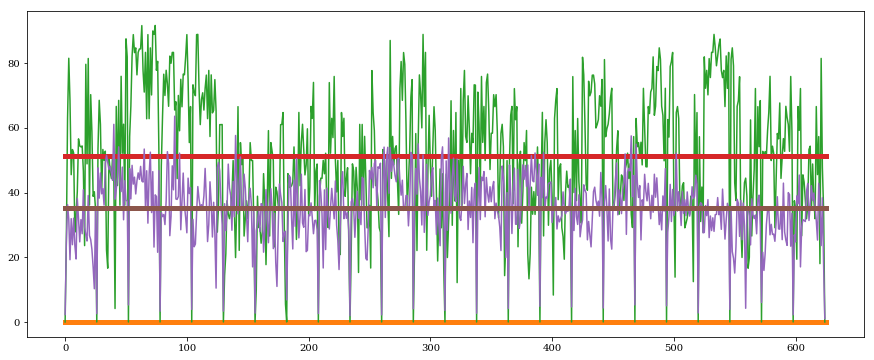

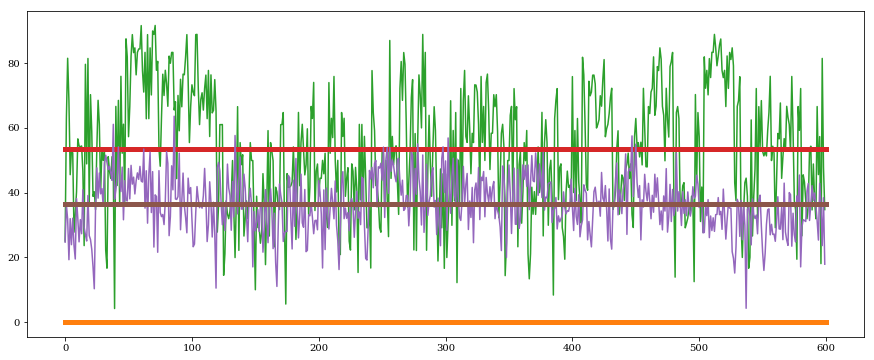

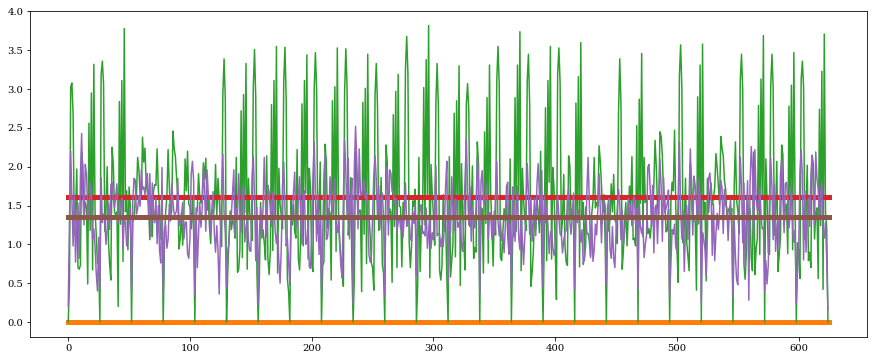

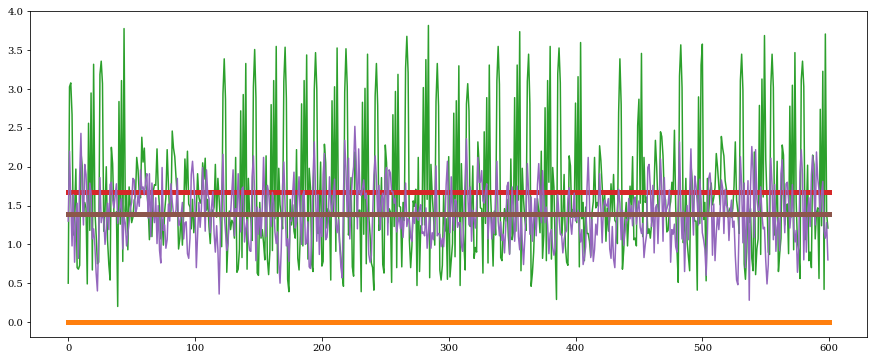

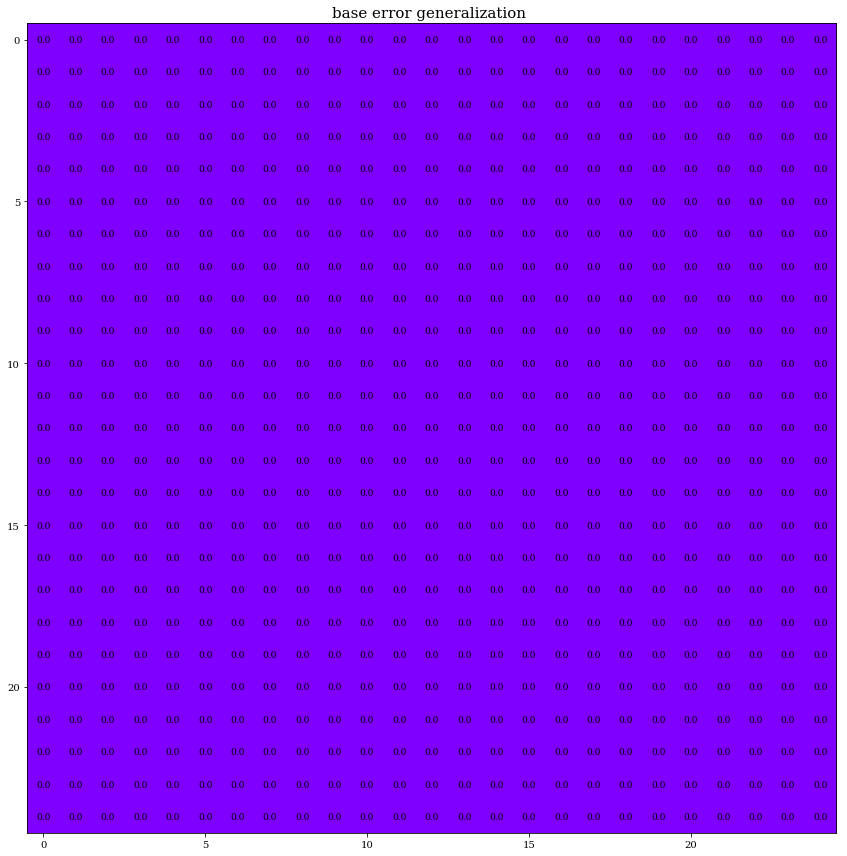

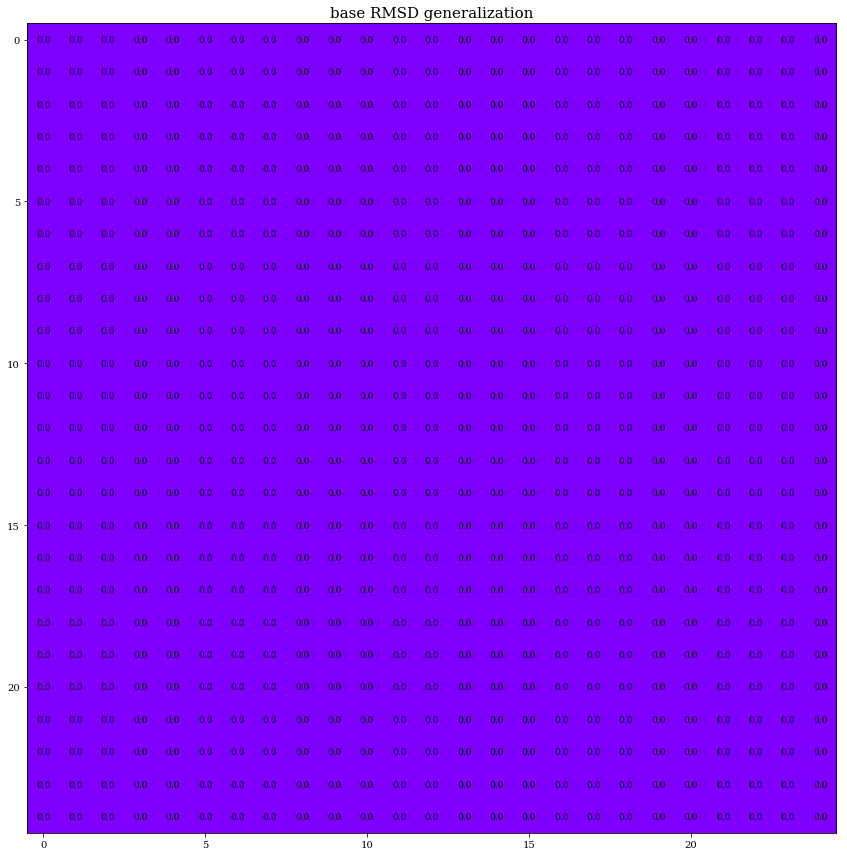

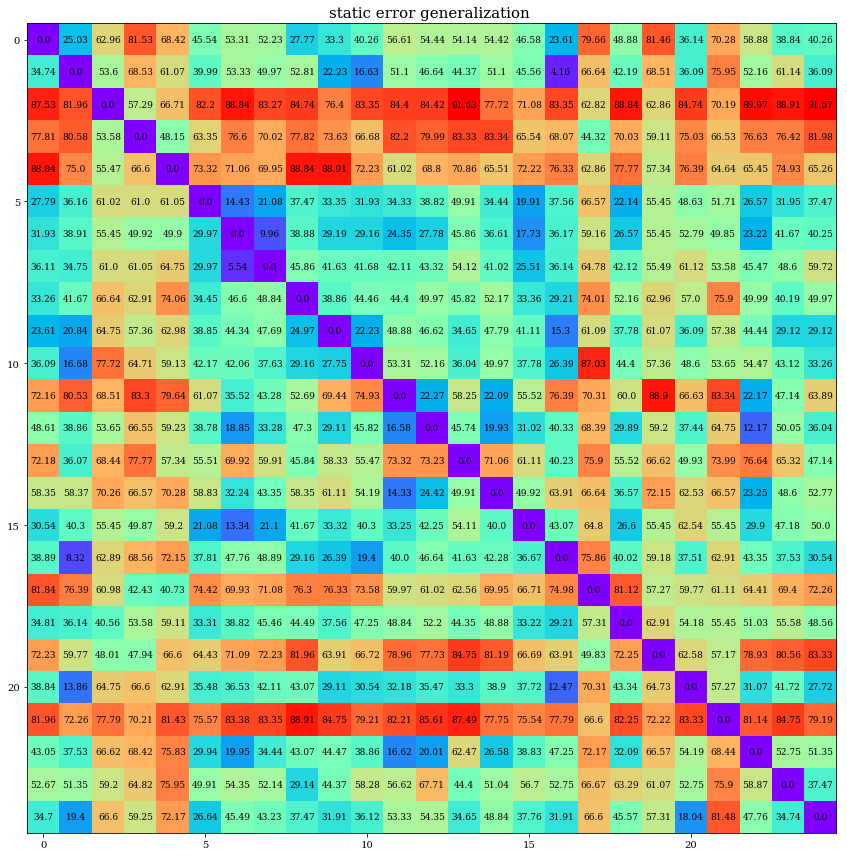

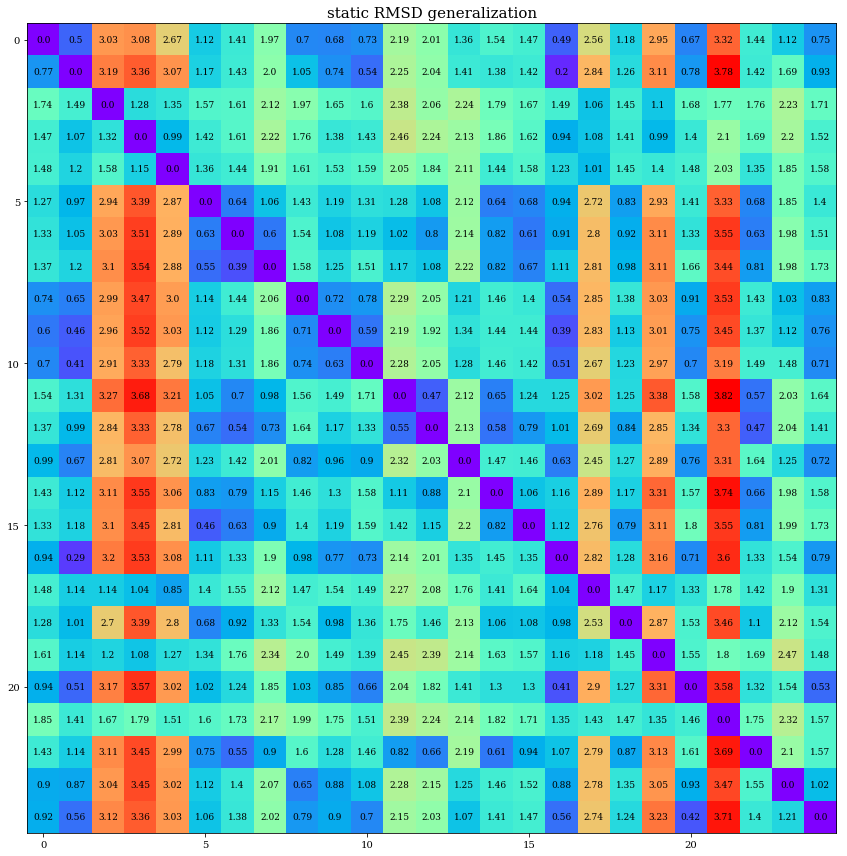

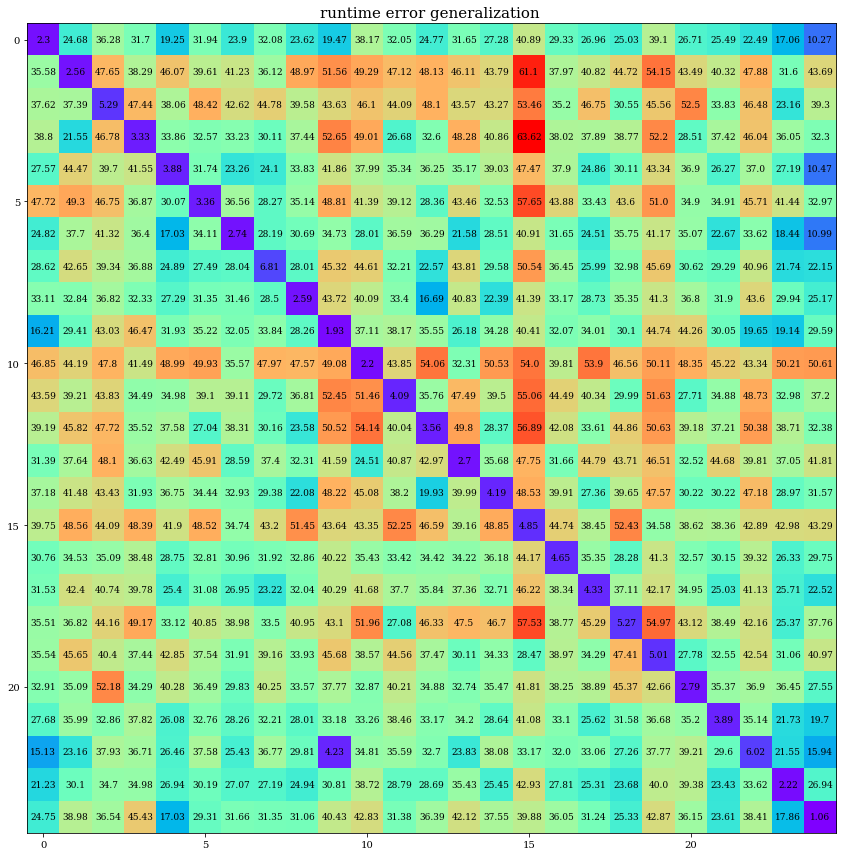

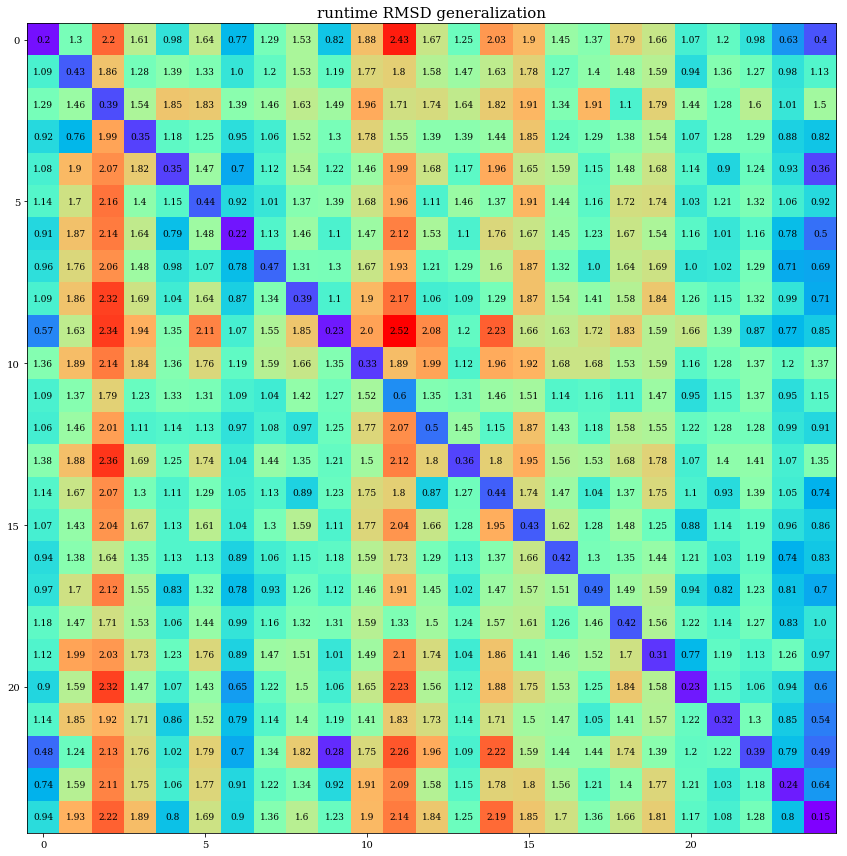

In [15]:
def get_errors_and_rmsd_without_self(results, errors, rms, errors_without_self, RMSDs_without_self):
    get_errors_and_rmsd(results, errors, rms)
    for i in range(0,N):
        for j in range(0,N):            
            if(i!=j):
                errors_without_self.append(errors[i*N+j])
                RMSDs_without_self.append(rms[i*N+j])

base_errors = []
base_rmsd = []
base_errors_without_self = []
base_rmsd_without_self = []
get_errors_and_rmsd_without_self(base_results, base_errors, base_rmsd, base_errors_without_self, base_rmsd_without_self)
base_std_error = np.std(base_errors)
base_std_error_without = np.std(base_errors_without_self)
print(base_std_error, ' ', base_std_error_without)

static_errors = []
static_rmsd = []
static_errors_without_self = []
static_rmsd_without_self = []
get_errors_and_rmsd_without_self(static_results, static_errors, static_rmsd, static_errors_without_self, static_rmsd_without_self)                
static_std_error = np.std(static_errors)
static_std_error_without = np.std(static_errors_without_self)
print(static_std_error, ' ', static_std_error_without)

runtime_errors = []
runtime_rmsd = []
runtime_errors_without_self = []
runtime_rmsd_without_self = []
get_errors_and_rmsd_without_self(runtime_results, runtime_errors, runtime_rmsd, runtime_errors_without_self, runtime_rmsd_without_self)                
runtime_std_error = np.std(runtime_errors)
runtime_std_error_without = np.std(runtime_errors_without_self)
print(runtime_std_error, ' ', runtime_std_error_without)

plt.figure(6, figsize=(15,6))
plt.plot(base_errors)
mean = np.mean(base_errors)
plt.plot([0, len(base_errors)], [mean, mean], linewidth=5)
plt.plot(static_errors)
mean = np.mean(static_errors)
plt.plot([0, len(static_errors)], [mean, mean], linewidth=5)
plt.plot(runtime_errors)
mean = np.mean(runtime_errors)
plt.plot([0, len(runtime_errors)], [mean, mean], linewidth=5)
plt.show()

plt.figure(7, figsize=(15,6))
plt.plot(base_errors_without_self)
mean = np.mean(base_errors_without_self)
plt.plot([0, len(base_errors_without_self)], [mean, mean], linewidth=5)
plt.plot(static_errors_without_self)
mean = np.mean(static_errors_without_self)
plt.plot([0, len(static_errors_without_self)], [mean, mean], linewidth=5)
plt.plot(runtime_errors_without_self)
mean = np.mean(runtime_errors_without_self)
plt.plot([0, len(runtime_errors_without_self)], [mean, mean], linewidth=5)
plt.show()

plt.figure(8, figsize=(15,6))
plt.plot(base_rmsd)
mean = np.mean(base_rmsd)
plt.plot([0, len(base_rmsd)], [mean, mean], linewidth=5)
plt.plot(static_rmsd)
mean = np.mean(static_rmsd)
plt.plot([0, len(static_rmsd)], [mean, mean], linewidth=5)
plt.plot(runtime_rmsd)
mean = np.mean(runtime_rmsd)
plt.plot([0, len(runtime_rmsd)], [mean, mean], linewidth=5)
plt.show()

plt.figure(9, figsize=(15,6))
plt.plot(base_rmsd_without_self)
mean = np.mean(base_rmsd_without_self)
plt.plot([0, len(base_rmsd_without_self)], [mean, mean], linewidth=5)
plt.plot(static_rmsd_without_self)
mean = np.mean(static_rmsd_without_self)
plt.plot([0, len(static_rmsd_without_self)], [mean, mean], linewidth=5)
plt.plot(runtime_rmsd_without_self)
mean = np.mean(runtime_rmsd_without_self)
plt.plot([0, len(runtime_rmsd_without_self)], [mean, mean], linewidth=5)
plt.show()

def get_error_rmsd_matrices(errors, rmsd, error_matrix, rmsd_matrix):
    for i in range(0,N):
        for j in range(0,N):
            error_matrix[i][j] = errors[N*i+j]
            rmsd_matrix[i][j] = rmsd[N*i+j]
            
base_error_matrix = np.empty([N,N], dtype=float)
base_rmsd_matrix = np.empty([N,N], dtype=float)
get_error_rmsd_matrices(base_errors, base_rmsd, base_error_matrix, base_rmsd_matrix)

static_error_matrix = np.empty([N,N], dtype=float)
static_rmsd_matrix = np.empty([N,N], dtype=float)
get_error_rmsd_matrices(static_errors, static_rmsd, static_error_matrix, static_rmsd_matrix)

runtime_error_matrix = np.empty([N,N], dtype=float)
runtime_rmsd_matrix = np.empty([N,N], dtype=float)
get_error_rmsd_matrices(runtime_errors, runtime_rmsd, runtime_error_matrix, runtime_rmsd_matrix)

def plot_matrices(error_matrix, rmsd_matrix, mode):       
    #Display error matrix  
    fig, ax = plt.subplots(figsize=(int(N/2), int(N/2)))
    im = ax.imshow(error_matrix, cmap=colormap)
    for i in range(0,N):
        for j in range(0,N):
            text = ax.text(j, i, error_matrix[i, j], ha="center", va="center", color="black", fontsize = 9)

    ax.set_title(mode+" error generalization ", fontsize = 15)
    fig.tight_layout()
    plt.show()
    plt.savefig(mode+'_error_generalization.png', dpi=300)


    #Display RMSD matrix
    fig, ax = plt.subplots(figsize=(int(N/2), int(N/2)))
    im = ax.imshow(rmsd_matrix, cmap=colormap)
    for i in range(0,N):
        for j in range(0,N):
            text = ax.text(j, i, rmsd_matrix[i, j], ha="center", va="center", color="black", fontsize = 9)

    ax.set_title(mode+" RMSD generalization", fontsize = 15)
    fig.tight_layout()
    plt.show()
    plt.savefig(mode+'_rmsd_generalization.png', dpi=300)
    
plot_matrices(base_error_matrix, base_rmsd_matrix, 'base')
plot_matrices(static_error_matrix, static_rmsd_matrix, 'static')    
plot_matrices(runtime_error_matrix, runtime_rmsd_matrix, 'runtime')    

In [16]:
def xp3(train_set, test_set, mode):
    for i in range(0,N,5):    
        print('training model on protocols', str(i), '-', str(i+4))
        train = series_to_supervised(list(train_set[i]), size_of_window, 1)
        test = series_to_supervised(list(test_set[i]), size_of_window, 1) 
        train_X_block, train_Y_block, test_X, test_Y = reshape(train, test)
        for j in range(i,i+5):
            train = series_to_supervised(list(train_set[j]), size_of_window, 1)
            test = series_to_supervised(list(test_set[j]), size_of_window, 1)
            train_X, train_Y, _, _ = reshape(train, test)
            train_X_block = np.concatenate((train_X_block, train_X), 0)
            train_Y_block = np.concatenate((train_Y_block, train_Y), 0)
        
        model = keras_model(train_X.shape[2], train_X.shape[1])
        train_start = datetime.datetime.now()
        model = train_and_save(model, train_X_block, train_Y_block, test_X, test_Y, mode, i+2000)#FIXME: split train_and_save into 2 def
        train_stop = datetime.datetime.now()
        train_duration = train_stop - train_start
        
        for j in range(0,N):
            print('using model trained on protocols', str(i), '-', str(i+4), ' on data coming from ', str(j))
            train = series_to_supervised(list(train_set[j]), size_of_window, 1)
            test = series_to_supervised(list(test_set[j]), size_of_window, 1) 
            train_X, train_Y, test_X, test_Y = reshape(train, test)
            predict_start = datetime.datetime.now()
            match_ratio, RMSD = predict(model, test_X, test_Y)
            predict_stop = datetime.datetime.now()
            predict_duration = predict_stop - predict_start
            print('RMSD = ', RMSD)
            print(match_ratio, '% error')
            print('training duration = ', train_duration)
            print('prediction duration = ', predict_duration)
            yield match_ratio, RMSD, train_duration, predict_duration

runtime_results = xp3(runtime_train, runtime_test, 'runtime')
runtime_results = list(runtime_results)

static_results = xp3(static_train, static_test, 'static')
static_results = list(static_results)

base_results = xp3(base_train, base_test, 'base')
base_results = list(base_results)

training model on protocols 0 - 4
Train on 23911 samples, validate on 2657 samples
Epoch 1/100
23911/23911 [==============================] - 71s 3ms/step - loss: 0.4679 - val_loss: 0.2675
Epoch 2/100
23911/23911 [==============================] - 29s 1ms/step - loss: 0.1987 - val_loss: 0.1940
Epoch 3/100
23911/23911 [==============================] - 29s 1ms/step - loss: 0.1590 - val_loss: 0.1635
Epoch 4/100
23911/23911 [==============================] - 29s 1ms/step - loss: 0.1398 - val_loss: 0.1868
Epoch 5/100
23911/23911 [==============================] - 29s 1ms/step - loss: 0.1313 - val_loss: 0.1397
Epoch 6/100
23911/23911 [==============================] - 29s 1ms/step - loss: 0.1228 - val_loss: 0.1555
Epoch 7/100
23911/23911 [==============================] - 29s 1ms/step - loss: 0.1164 - val_loss: 0.1443
Epoch 8/100
23911/23911 [==============================] - 29s 1ms/step - loss: 0.1148 - val_loss: 0.1189
Epoch 9/100
23911/23911 [==============================] - 29s 1ms/st

23712/23712 [==============================] - 29s 1ms/step - loss: 0.1400 - val_loss: 0.0930
Epoch 15/100
23712/23712 [==============================] - 29s 1ms/step - loss: 0.1355 - val_loss: 0.0965
Epoch 16/100
23712/23712 [==============================] - 29s 1ms/step - loss: 0.1340 - val_loss: 0.0948
Epoch 17/100
23712/23712 [==============================] - 29s 1ms/step - loss: 0.1339 - val_loss: 0.0939
Epoch 18/100
23712/23712 [==============================] - 29s 1ms/step - loss: 0.1308 - val_loss: 0.0892
Epoch 19/100
23712/23712 [==============================] - 29s 1ms/step - loss: 0.1323 - val_loss: 0.0934
Epoch 20/100
23712/23712 [==============================] - 29s 1ms/step - loss: 0.1292 - val_loss: 0.0910
Epoch 21/100
23712/23712 [==============================] - 29s 1ms/step - loss: 0.1315 - val_loss: 0.0927
Epoch 22/100
23712/23712 [==============================] - 29s 1ms/step - loss: 0.1285 - val_loss: 0.0942
Epoch 23/100
23712/23712 [========================

23600/23600 [==============================] - 29s 1ms/step - loss: 0.1477 - val_loss: 0.2674
Epoch 24/100
23600/23600 [==============================] - 29s 1ms/step - loss: 0.1484 - val_loss: 0.2399
Epoch 25/100
23600/23600 [==============================] - 29s 1ms/step - loss: 0.1466 - val_loss: 0.2601
Epoch 26/100
23600/23600 [==============================] - 29s 1ms/step - loss: 0.1460 - val_loss: 0.2385
Epoch 27/100
23600/23600 [==============================] - 29s 1ms/step - loss: 0.1451 - val_loss: 0.2484
Epoch 28/100
23600/23600 [==============================] - 29s 1ms/step - loss: 0.1437 - val_loss: 0.2414
Epoch 00028: early stopping
using model trained on protocols 10 - 14  on data coming from  0
RMSD =  1.24
31.379999999999995 % error
training duration =  0:14:18.034797
prediction duration =  0:00:13.727820
using model trained on protocols 10 - 14  on data coming from  1
RMSD =  1.28
32.22 % error
training duration =  0:14:18.034797
prediction duration =  0:00:00.45323

23179/23179 [==============================] - 29s 1ms/step - loss: 0.1125 - val_loss: 0.1559
Epoch 31/100
23179/23179 [==============================] - 29s 1ms/step - loss: 0.1127 - val_loss: 0.1598
Epoch 32/100
23179/23179 [==============================] - 29s 1ms/step - loss: 0.1114 - val_loss: 0.1796
Epoch 33/100
23179/23179 [==============================] - 29s 1ms/step - loss: 0.1105 - val_loss: 0.1769
Epoch 34/100
23179/23179 [==============================] - 29s 1ms/step - loss: 0.1108 - val_loss: 0.1577
Epoch 00034: early stopping
using model trained on protocols 15 - 19  on data coming from  0
RMSD =  1.17
25.239999999999995 % error
training duration =  0:17:00.553777
prediction duration =  0:00:13.716902
using model trained on protocols 15 - 19  on data coming from  1
RMSD =  1.24
33.06999999999999 % error
training duration =  0:17:00.553777
prediction duration =  0:00:00.457216
using model trained on protocols 15 - 19  on data coming from  2
RMSD =  1.69
33.91 % error
t

RMSD =  1.41
31.25 % error
training duration =  0:13:12.153868
prediction duration =  0:00:00.482281
using model trained on protocols 20 - 24  on data coming from  4
RMSD =  0.65
20.72 % error
training duration =  0:13:12.153868
prediction duration =  0:00:00.549489
using model trained on protocols 20 - 24  on data coming from  5
RMSD =  1.46
31.620000000000005 % error
training duration =  0:13:12.153868
prediction duration =  0:00:00.493341
using model trained on protocols 20 - 24  on data coming from  6
RMSD =  0.59
19.459999999999994 % error
training duration =  0:13:12.153868
prediction duration =  0:00:00.494341
using model trained on protocols 20 - 24  on data coming from  7
RMSD =  1.11
30.730000000000004 % error
training duration =  0:13:12.153868
prediction duration =  0:00:00.503366
using model trained on protocols 20 - 24  on data coming from  8
RMSD =  1.43
27.489999999999995 % error
training duration =  0:13:12.153868
prediction duration =  0:00:00.596613
using model train

RMSD =  0.57
31.950000000000003 % error
training duration =  0:04:26.526719
prediction duration =  0:00:00.483257
using model trained on protocols 0 - 4  on data coming from  21
RMSD =  1.33
31.33 % error
training duration =  0:04:26.526719
prediction duration =  0:00:00.355973
using model trained on protocols 0 - 4  on data coming from  22
RMSD =  1.95
56.62 % error
training duration =  0:04:26.526719
prediction duration =  0:00:00.595583
using model trained on protocols 0 - 4  on data coming from  23
RMSD =  0.93
20.790000000000006 % error
training duration =  0:04:26.526719
prediction duration =  0:00:00.483314
using model trained on protocols 0 - 4  on data coming from  24
RMSD =  0.61
24.950000000000003 % error
training duration =  0:04:26.526719
prediction duration =  0:00:00.478272
training model on protocols 5 - 9
Train on 25023 samples, validate on 2781 samples
Epoch 1/100
25023/25023 [==============================] - 78s 3ms/step - loss: 0.0220 - val_loss: 4.1335e-04
Epoch 2

RMSD =  0.57
22.200000000000003 % error
training duration =  0:05:34.229197
prediction duration =  0:00:00.607642
using model trained on protocols 10 - 14  on data coming from  7
RMSD =  0.8
32.230000000000004 % error
training duration =  0:05:34.229197
prediction duration =  0:00:00.612656
using model trained on protocols 10 - 14  on data coming from  8
RMSD =  0.54
16.629999999999995 % error
training duration =  0:05:34.229197
prediction duration =  0:00:00.488325
using model trained on protocols 10 - 14  on data coming from  9
RMSD =  0.55
18.019999999999996 % error
training duration =  0:05:34.229197
prediction duration =  0:00:00.492337
using model trained on protocols 10 - 14  on data coming from  10
RMSD =  0.0
0.0 % error
training duration =  0:05:34.229197
prediction duration =  0:00:00.490330
using model trained on protocols 10 - 14  on data coming from  11
RMSD =  0.0
0.0 % error
training duration =  0:05:34.229197
prediction duration =  0:00:00.611630
using model trained on

RMSD =  1.03
48.81 % error
training duration =  0:05:44.127309
prediction duration =  0:00:00.614509
using model trained on protocols 15 - 19  on data coming from  23
RMSD =  2.21
54.16 % error
training duration =  0:05:44.127309
prediction duration =  0:00:00.493338
using model trained on protocols 15 - 19  on data coming from  24
RMSD =  1.15
37.51 % error
training duration =  0:05:44.127309
prediction duration =  0:00:00.489328
training model on protocols 20 - 24
Train on 21405 samples, validate on 2379 samples
Epoch 1/100
21405/21405 [==============================] - 75s 4ms/step - loss: 0.0456 - val_loss: 0.0144
Epoch 2/100
21405/21405 [==============================] - 29s 1ms/step - loss: 0.0026 - val_loss: 3.6302e-04
Epoch 3/100
21405/21405 [==============================] - 29s 1ms/step - loss: 0.0028 - val_loss: 9.1877e-05
Epoch 4/100
21405/21405 [==============================] - 29s 1ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 5/100
21405/21405 [=======================

RMSD =  0.0
0.0 % error
training duration =  0:04:05.989077
prediction duration =  0:00:00.369009
using model trained on protocols 0 - 4  on data coming from  8
RMSD =  0.0
0.0 % error
training duration =  0:04:05.989077
prediction duration =  0:00:00.368007
using model trained on protocols 0 - 4  on data coming from  9
RMSD =  0.0
0.0 % error
training duration =  0:04:05.989077
prediction duration =  0:00:00.374999
using model trained on protocols 0 - 4  on data coming from  10
RMSD =  0.0
0.0 % error
training duration =  0:04:05.989077
prediction duration =  0:00:00.369009
using model trained on protocols 0 - 4  on data coming from  11
RMSD =  0.0
0.0 % error
training duration =  0:04:05.989077
prediction duration =  0:00:00.373026
using model trained on protocols 0 - 4  on data coming from  12
RMSD =  0.0
0.0 % error
training duration =  0:04:05.989077
prediction duration =  0:00:00.370013
using model trained on protocols 0 - 4  on data coming from  13
RMSD =  0.0
0.0 % error
traini

15978/15978 [==============================] - 69s 4ms/step - loss: 0.0295 - val_loss: 4.5949e-12
Epoch 2/100
15978/15978 [==============================] - 22s 1ms/step - loss: 0.0011 - val_loss: 1.5856e-07
Epoch 3/100
15978/15978 [==============================] - 22s 1ms/step - loss: 4.6299e-06 - val_loss: 2.0472e-04
Epoch 4/100
15978/15978 [==============================] - 22s 1ms/step - loss: 0.0010 - val_loss: 2.9536e-11
Epoch 5/100
15978/15978 [==============================] - 22s 1ms/step - loss: 8.1714e-11 - val_loss: 1.0204e-08
Epoch 6/100
15978/15978 [==============================] - 22s 1ms/step - loss: 4.2436e-04 - val_loss: 4.1718e-09
Epoch 7/100
15978/15978 [==============================] - 22s 1ms/step - loss: 2.0118e-04 - val_loss: 1.3674e-09
Epoch 8/100
15978/15978 [==============================] - 22s 1ms/step - loss: 2.7006e-04 - val_loss: 3.4354e-08
Epoch 9/100
15978/15978 [==============================] - 22s 1ms/step - loss: 9.1611e-05 - val_loss: 2.4719e-0

RMSD =  0.0
0.0 % error
training duration =  0:04:05.081347
prediction duration =  0:00:00.377029
using model trained on protocols 15 - 19  on data coming from  13
RMSD =  0.0
0.0 % error
training duration =  0:04:05.081347
prediction duration =  0:00:00.374022
using model trained on protocols 15 - 19  on data coming from  14
RMSD =  0.0
0.0 % error
training duration =  0:04:05.081347
prediction duration =  0:00:00.372016
using model trained on protocols 15 - 19  on data coming from  15
RMSD =  0.0
0.0 % error
training duration =  0:04:05.081347
prediction duration =  0:00:00.377029
using model trained on protocols 15 - 19  on data coming from  16
RMSD =  0.0
0.0 % error
training duration =  0:04:05.081347
prediction duration =  0:00:00.375005
using model trained on protocols 15 - 19  on data coming from  17
RMSD =  0.0
0.0 % error
training duration =  0:04:05.081347
prediction duration =  0:00:00.373990
using model trained on protocols 15 - 19  on data coming from  18
RMSD =  0.0
0.0 

0.0   0.0
21.4888779946   17.8345452364
11.4624772342   7.59838371234


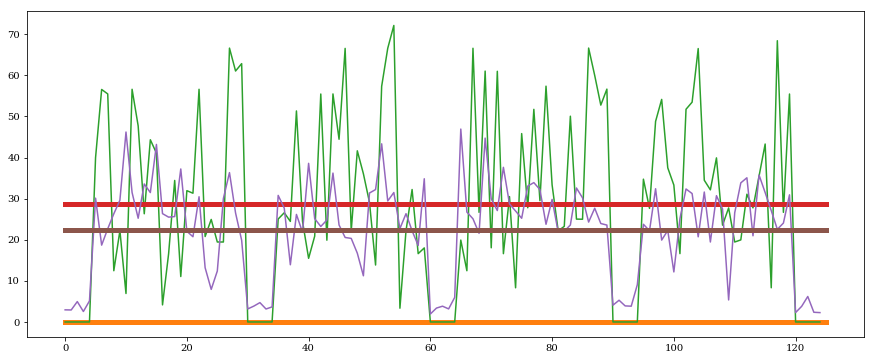

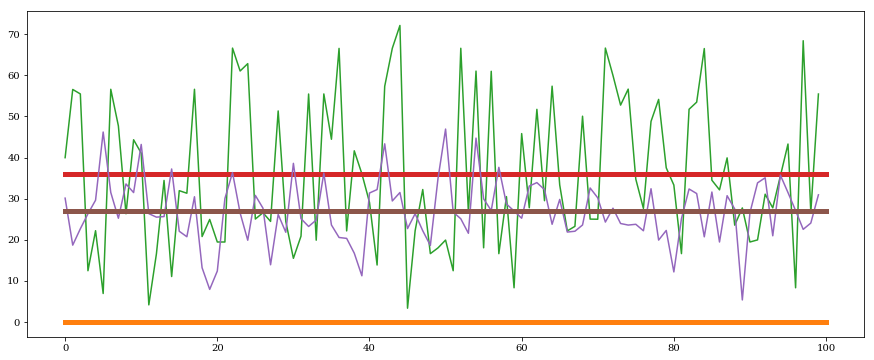

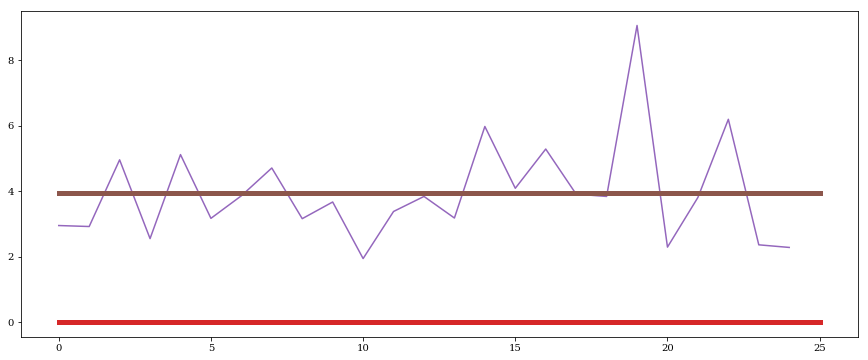

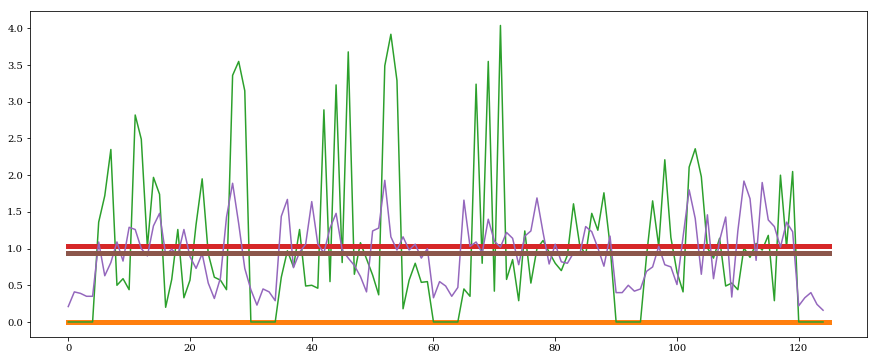

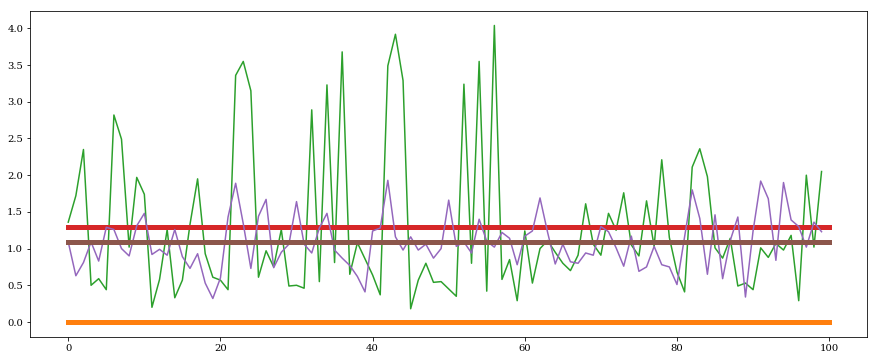

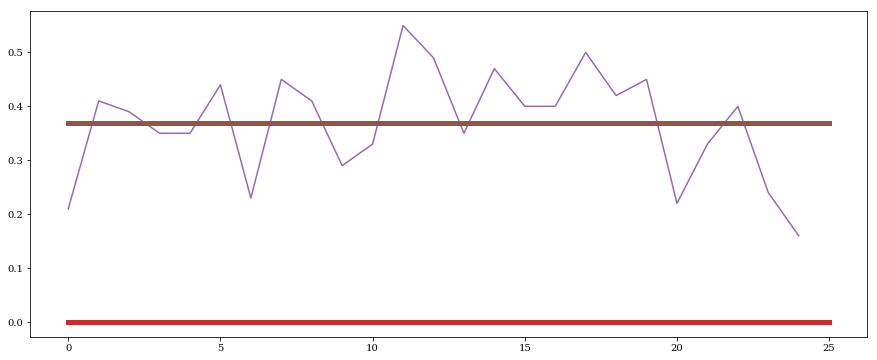

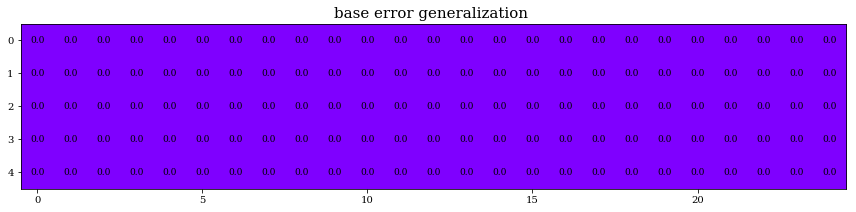

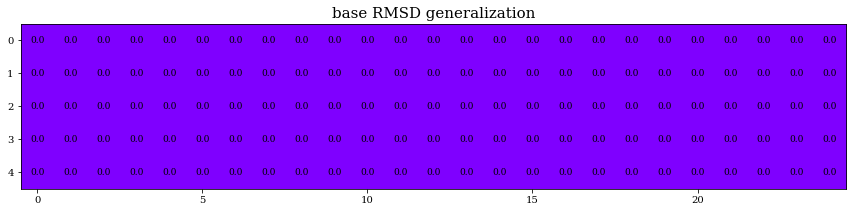

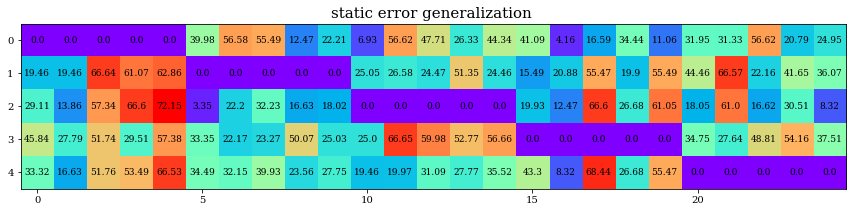

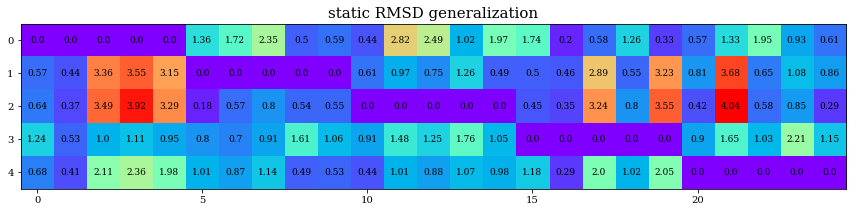

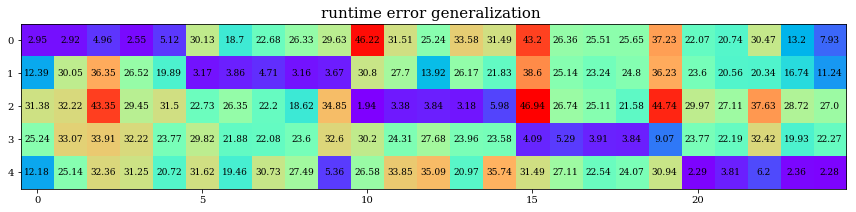

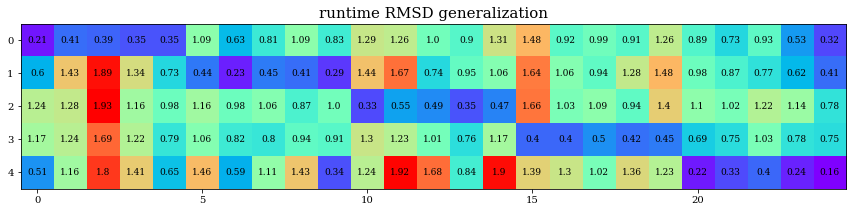

In [17]:
def get_errors_and_rmsd_without_self2(results, errors, rms, errors_without_self, RMSDs_without_self, self_errors, self_RMSDs, skip=5):
    get_errors_and_rmsd(results, errors, rms)
    s = 0
    r = 0
    for i in range(0,len(errors)):
        if s < skip:
            self_errors.append(errors[i])
            self_RMSDs.append(rms[i])
            s = s + 1            
        else:
            errors_without_self.append(errors[i])
            RMSDs_without_self.append(rms[i])
            r = r + 1           
            if (r >= N):
                r = 0
                s = 0
        
base_errors = []
base_rmsd = []
base_errors_w = []
base_rmsd_w = []
self_base_errors = []
self_base_rmsd = []
get_errors_and_rmsd_without_self2(base_results, base_errors, base_rmsd, base_errors_w, base_rmsd_w, self_base_errors, self_base_rmsd)
base_std_error = np.std(base_errors)
base_std_error_w = np.std(base_errors_w)
print(base_std_error, ' ', base_std_error_w)

static_errors = []
static_rmsd = []
static_errors_w = []
static_rmsd_w = []
self_static_errors = []
self_static_rmsd = []
get_errors_and_rmsd_without_self2(static_results, static_errors, static_rmsd, static_errors_w, static_rmsd_w, self_static_errors, self_static_rmsd)                
static_std_error = np.std(static_errors)
static_std_error_w = np.std(static_errors_w)
print(static_std_error, ' ', static_std_error_w)

runtime_errors = []
runtime_rmsd = []
runtime_errors_w = []
runtime_rmsd_w = []
self_runtime_errors = []
self_runtime_rmsd = []
get_errors_and_rmsd_without_self2(runtime_results, runtime_errors, runtime_rmsd, runtime_errors_w, runtime_rmsd_w, self_runtime_errors, self_runtime_rmsd)                
runtime_std_error = np.std(runtime_errors)
runtime_std_error_w = np.std(runtime_errors_w)
print(runtime_std_error, ' ', runtime_std_error_w)

plt.figure(10, figsize=(15,6))
plt.plot(base_errors)
mean = np.mean(base_errors)
plt.plot([0, len(base_errors)], [mean, mean], linewidth=5)
plt.plot(static_errors)
mean = np.mean(static_errors)
plt.plot([0, len(static_errors)], [mean, mean], linewidth=5)
plt.plot(runtime_errors)
mean = np.mean(runtime_errors)
plt.plot([0, len(runtime_errors)], [mean, mean], linewidth=5)
plt.show()

plt.figure(11, figsize=(15,6))
plt.plot(base_errors_w)
mean = np.mean(base_errors_w)
plt.plot([0, len(base_errors_w)], [mean, mean], linewidth=5)
plt.plot(static_errors_w)
mean = np.mean(static_errors_w)
plt.plot([0, len(static_errors_w)], [mean, mean], linewidth=5)
plt.plot(runtime_errors_w)
mean = np.mean(runtime_errors_w)
plt.plot([0, len(runtime_errors_w)], [mean, mean], linewidth=5)
plt.show()

plt.figure(12, figsize=(15,6))
plt.plot(self_base_errors)
mean = np.mean(self_base_errors)
plt.plot([0, len(self_base_errors)], [mean, mean], linewidth=5)
plt.plot(self_static_errors)
mean = np.mean(self_static_errors)
plt.plot([0, len(self_static_errors)], [mean, mean], linewidth=5)
plt.plot(self_runtime_errors)
mean = np.mean(self_runtime_errors)
plt.plot([0, len(self_runtime_errors)], [mean, mean], linewidth=5)
plt.show()

plt.figure(13, figsize=(15,6))
plt.plot(base_rmsd)
mean = np.mean(base_rmsd)
plt.plot([0, len(base_rmsd)], [mean, mean], linewidth=5)
plt.plot(static_rmsd)
mean = np.mean(static_rmsd)
plt.plot([0, len(static_rmsd)], [mean, mean], linewidth=5)
plt.plot(runtime_rmsd)
mean = np.mean(runtime_rmsd)
plt.plot([0, len(runtime_rmsd)], [mean, mean], linewidth=5)
plt.show()

plt.figure(14, figsize=(15,6))
plt.plot(base_rmsd_w)
mean = np.mean(base_rmsd_w)
plt.plot([0, len(base_rmsd_w)], [mean, mean], linewidth=5)
plt.plot(static_rmsd_w)
mean = np.mean(static_rmsd_w)
plt.plot([0, len(static_rmsd_w)], [mean, mean], linewidth=5)
plt.plot(runtime_rmsd_w)
mean = np.mean(runtime_rmsd_w)
plt.plot([0, len(runtime_rmsd_w)], [mean, mean], linewidth=5)
plt.show()

plt.figure(15, figsize=(15,6))
plt.plot(self_base_rmsd)
mean = np.mean(self_base_rmsd)
plt.plot([0, len(self_base_rmsd)], [mean, mean], linewidth=5)
plt.plot(self_static_rmsd)
mean = np.mean(self_static_rmsd)
plt.plot([0, len(self_static_rmsd)], [mean, mean], linewidth=5)
plt.plot(self_runtime_rmsd)
mean = np.mean(self_runtime_rmsd)
plt.plot([0, len(self_runtime_rmsd)], [mean, mean], linewidth=5)
plt.show()

def get_error_rmsd_matrices2(errors, rmsd, error_matrix, rmsd_matrix, length=N):
    for i in range(0, len(errors)):
        row = math.floor(i/length)
        col = i % length
        error_matrix[row][col] = errors[i]
        rmsd_matrix[row][col] = rmsd[i]
            
x = math.floor(len(base_errors)/N)
y = N
base_error_matrix = np.empty([x,y], dtype=float)
base_rmsd_matrix = np.empty([x,y], dtype=float)
get_error_rmsd_matrices2(base_errors, base_rmsd, base_error_matrix, base_rmsd_matrix)

x = math.floor(len(static_errors)/N)
static_error_matrix = np.empty([x,y], dtype=float)
static_rmsd_matrix = np.empty([x,y], dtype=float)
get_error_rmsd_matrices2(static_errors, static_rmsd, static_error_matrix, static_rmsd_matrix)

x = math.floor(len(runtime_errors)/N)
runtime_error_matrix = np.empty([x,y], dtype=float)
runtime_rmsd_matrix = np.empty([x,y], dtype=float)
get_error_rmsd_matrices2(runtime_errors, runtime_rmsd, runtime_error_matrix, runtime_rmsd_matrix)


def plot_matrices2(error_matrix, rmsd_matrix, mode, x=N, y=N):       
    #Display error matrix  
    fig, ax = plt.subplots(figsize=(int(N/2), int(N/2)))
    im = ax.imshow(error_matrix, cmap=colormap)
    for i in range(0,x):
        for j in range(0,y):
            text = ax.text(j, i, error_matrix[i, j], ha="center", va="center", color="black", fontsize = 9)

    ax.set_title(mode+" error generalization ", fontsize = 15)
    fig.tight_layout()
    plt.show()
    plt.savefig(mode+'_error_generalization.png', dpi=300)


    #Display RMSD matrix
    fig, ax = plt.subplots(figsize=(int(N/2), int(N/2)))
    im = ax.imshow(rmsd_matrix, cmap=colormap)
    for i in range(0,x):
        for j in range(0,y):
            text = ax.text(j, i, rmsd_matrix[i, j], ha="center", va="center", color="black", fontsize = 9)

    ax.set_title(mode+" RMSD generalization", fontsize = 15)
    fig.tight_layout()
    plt.show()
    plt.savefig(mode+'_rmsd_generalization.png', dpi=300)

plot_matrices2(base_error_matrix, base_rmsd_matrix, 'base', x=5)
plot_matrices2(static_error_matrix, static_rmsd_matrix, 'static', x=5)    
plot_matrices2(runtime_error_matrix, runtime_rmsd_matrix, 'runtime', x=5)    